# **Business Case: Scaler - Clustering**


**Problem Statement**

Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.


The dataset contains following features:

‘Unnamed 0’- Index of the dataset

Email_hash- Anonymised Personal Identifiable Information (PII)

Company- Current employer of the learner
orgyear- Employment start date

CTC- Current CTC

Job_position- Job profile in the company

CTC_updated_year: Year in which CTC got updated (Yearly increments, Promotions)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import warnings


In [3]:
df_scaler = pd.read_csv("/content/sample_data/ScalerCase.txt")
df_scaler.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [4]:
df_scaler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153281 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [5]:
df_scaler.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,205843.0,1.032739e+05,5.974131e+04,0.0,51518.5,103151.0,154992.5,2.069220e+05
orgyear,205757.0,2.014883e+03,6.357112e+01,0.0,2013.0,2016.0,2018.0,2.016500e+04
ctc,205843.0,2.271685e+06,1.180091e+07,2.0,530000.0,950000.0,1700000.0,1.000150e+09
ctc_updated_year,205843.0,2.019628e+03,1.325104e+00,2015.0,2019.0,2020.0,2021.0,2.021000e+03


In [6]:
df_scaler.shape

(205843, 7)

**Checking for Null Values in dataset**

In [7]:
df_scaler.isna().sum()

Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52562
ctc_updated_year        0
dtype: int64

In [8]:
from sklearn.impute import KNNImputer

**Checking for Duplicate Rows in dataset**

In [9]:
len(df_scaler[df_scaler.duplicated()])

0

# **Data Preprocessing**

**Creating null value indicator columns (Feature Engineering)**

In [10]:
for i in ['orgyear','ctc_updated_year','company_hash','job_position']:
    df_scaler[i+'_na'] = df_scaler[i].isna()

**Cleaning text columns - Using regex to extract only alphnumeric vlues from the columns**

In [11]:
import re

In [12]:
text_cols = ['company_hash','email_hash']
for i in text_cols:
    df_scaler[i] = df_scaler[i].fillna('Not Available').apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', str(x).title()))

**Creating new columns (Feature Engineering)**

In [13]:
df_scaler['YoE'] = df_scaler['ctc_updated_year'] - df_scaler['orgyear']

**Frequency mean encoding**

In [14]:
feat = 'company_hash'
df_scaler[feat] = df_scaler[feat].fillna('na')
enc_nom = (df_scaler.groupby(feat).size()) / len(df_scaler)
df_scaler[feat+'_encode'] = df_scaler[feat].apply(lambda x : enc_nom[x])

feat = 'job_position'
df_scaler[feat] = df_scaler[feat].fillna('na')
enc_nom = (df_scaler.groupby(feat).size()) / len(df_scaler)*10000
df_scaler[feat+'_encode'] = df_scaler[feat].apply(lambda x : enc_nom[x])

**Reemoving Outliers from Orgyear column**

In [15]:
sorted(df_scaler['orgyear'].fillna(0).astype(int).unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 38,
 83,
 91,
 200,
 201,
 206,
 208,
 209,
 1900,
 1970,
 1971,
 1972,
 1973,
 1976,
 1977,
 1979,
 1981,
 1982,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2031,
 2101,
 2106,
 2107,
 2204,
 20165]

Removing future years, as this case is impossible to happen, also removing single digit years.



In [16]:
df_scaler = df_scaler[~df_scaler['orgyear'].isin([0,
 1,
 2,
 3,
 4,
 5,
 6,
 38,
 83,
 91,
 200,
 201,
 206,
 208,
 209,
 1900, 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2031,
 2101,
 2106,
 2107,
 2204,
 20165])]

In [17]:
df_scaler = df_scaler[~(df_scaler['YoE']<0)]

# **Exploratory Data Analysis**

**Univariate Analysis**

Univariate analysis involves examining the distribution of a single variable without considering any other variables. It is used to understand the characteristics of a single variable in a dataset.

In [18]:
categroical_columns = [ 'company_hash','job_position','orgyear','ctc_updated_year']

<ipython-input-19-dc3b5bde3fd8>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby(i).sum()['count'].reset_index().sort_values('count',ascending=False).head(15)


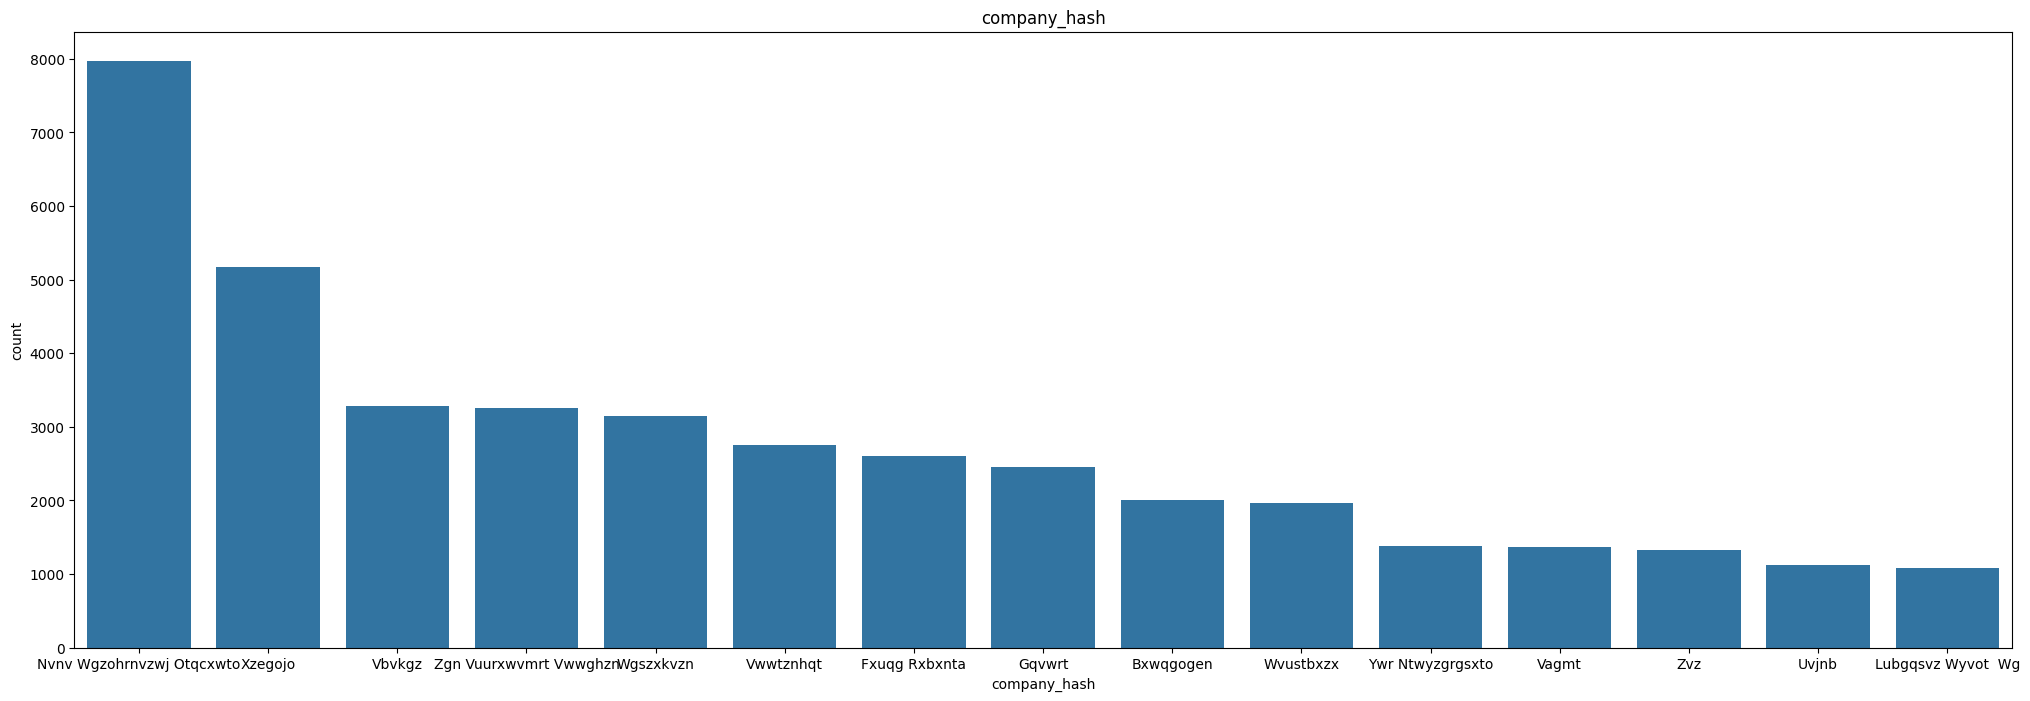

<ipython-input-19-dc3b5bde3fd8>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby(i).sum()['count'].reset_index().sort_values('count',ascending=False).head(15)


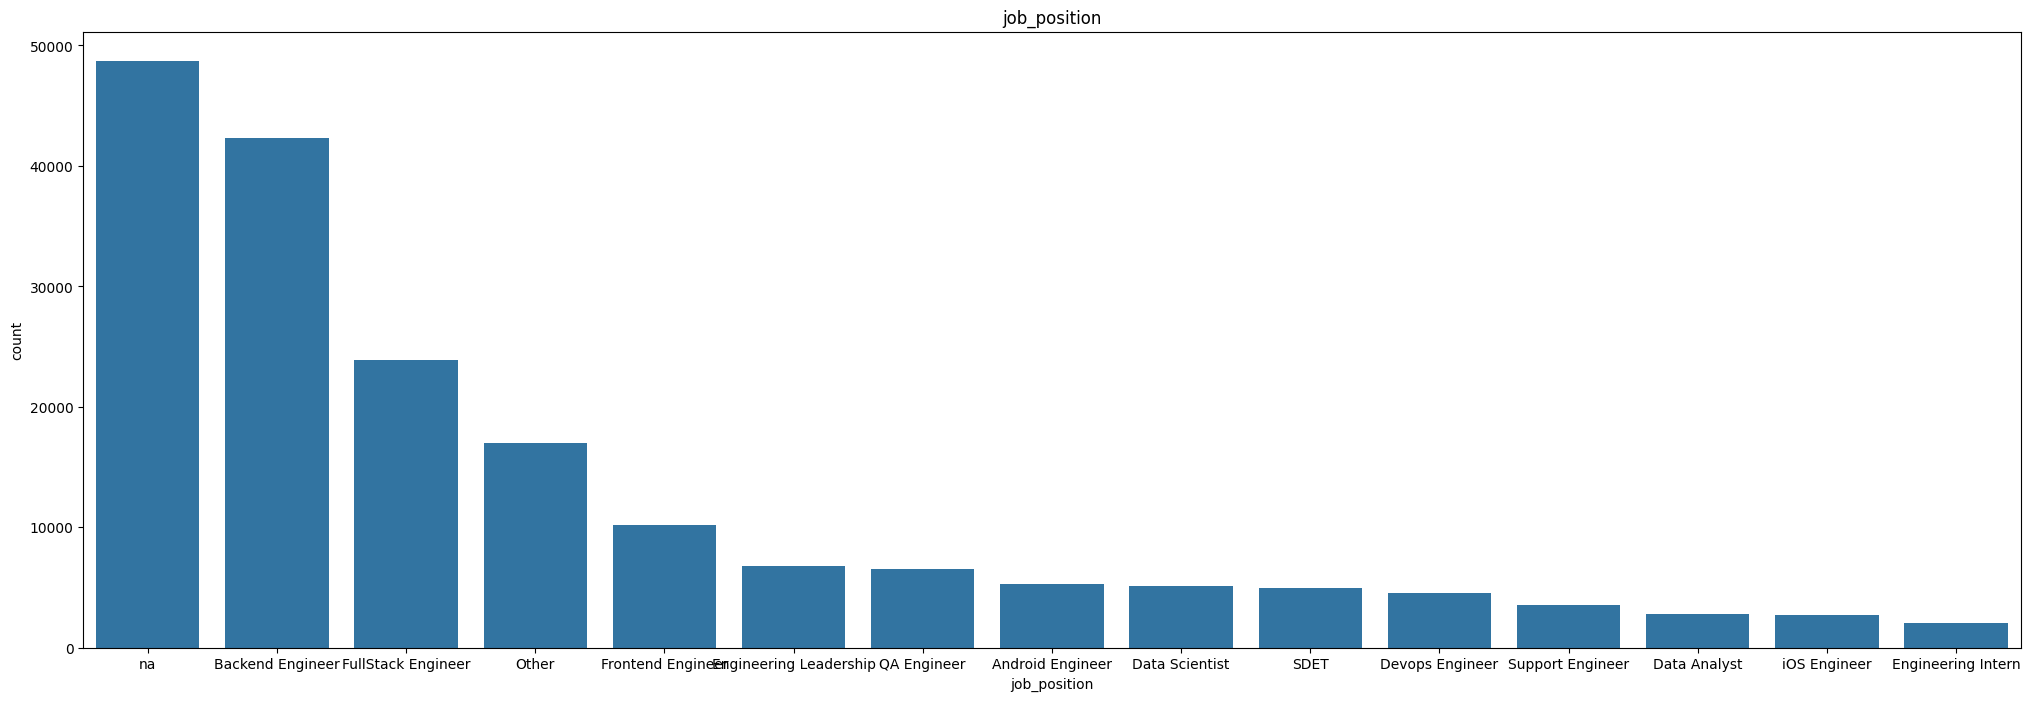

<ipython-input-19-dc3b5bde3fd8>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby(i).sum()['count'].reset_index().sort_values('count',ascending=False).head(15)


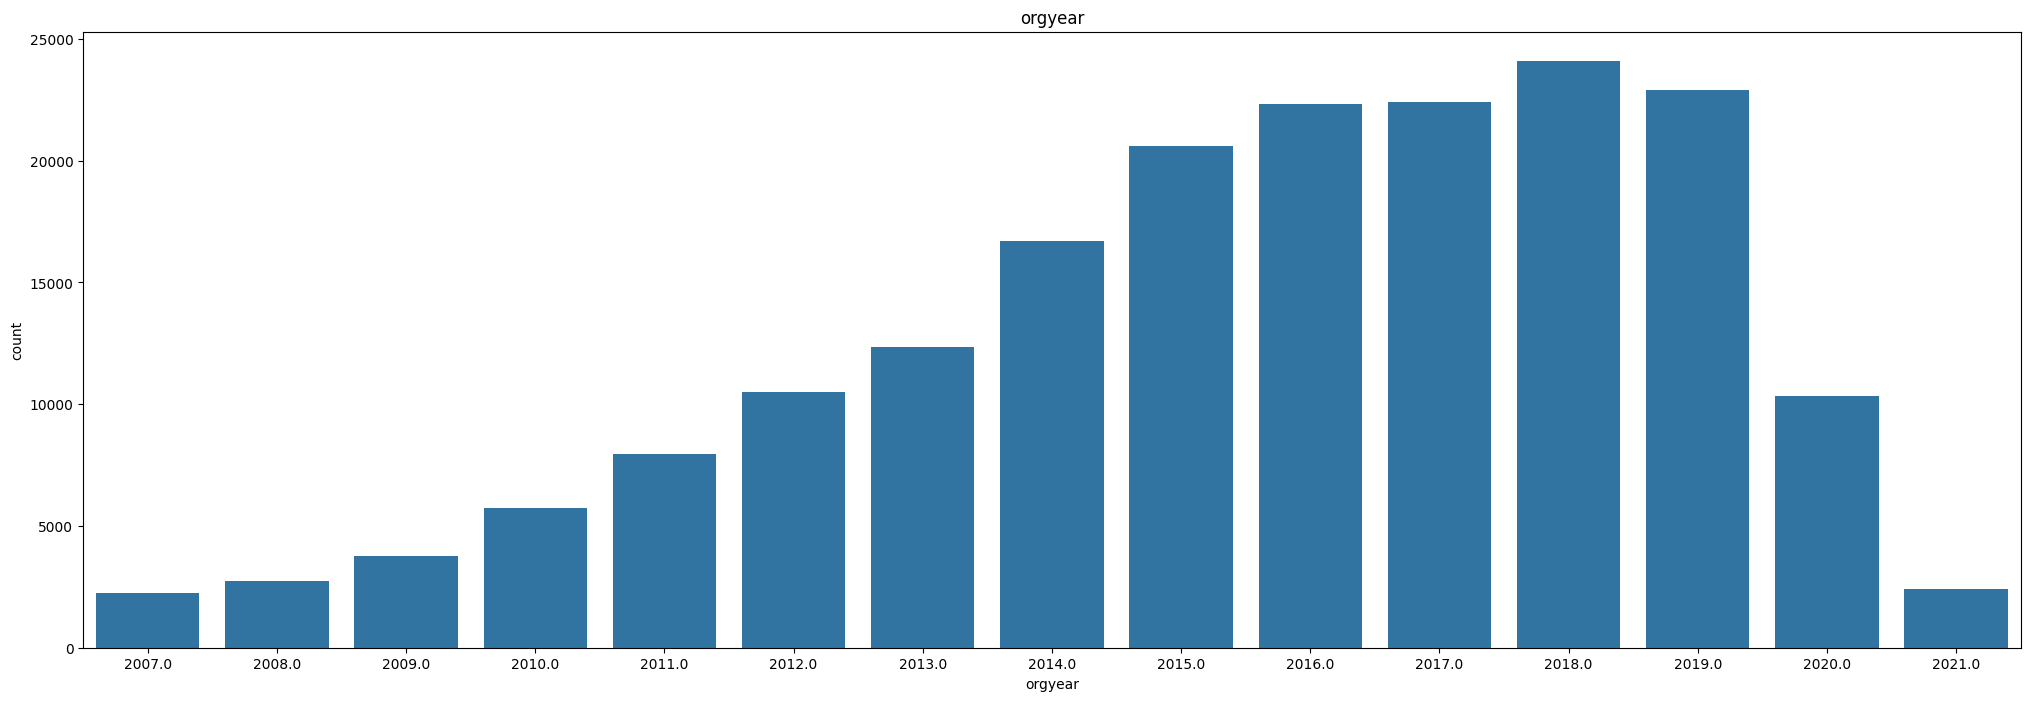

<ipython-input-19-dc3b5bde3fd8>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby(i).sum()['count'].reset_index().sort_values('count',ascending=False).head(15)


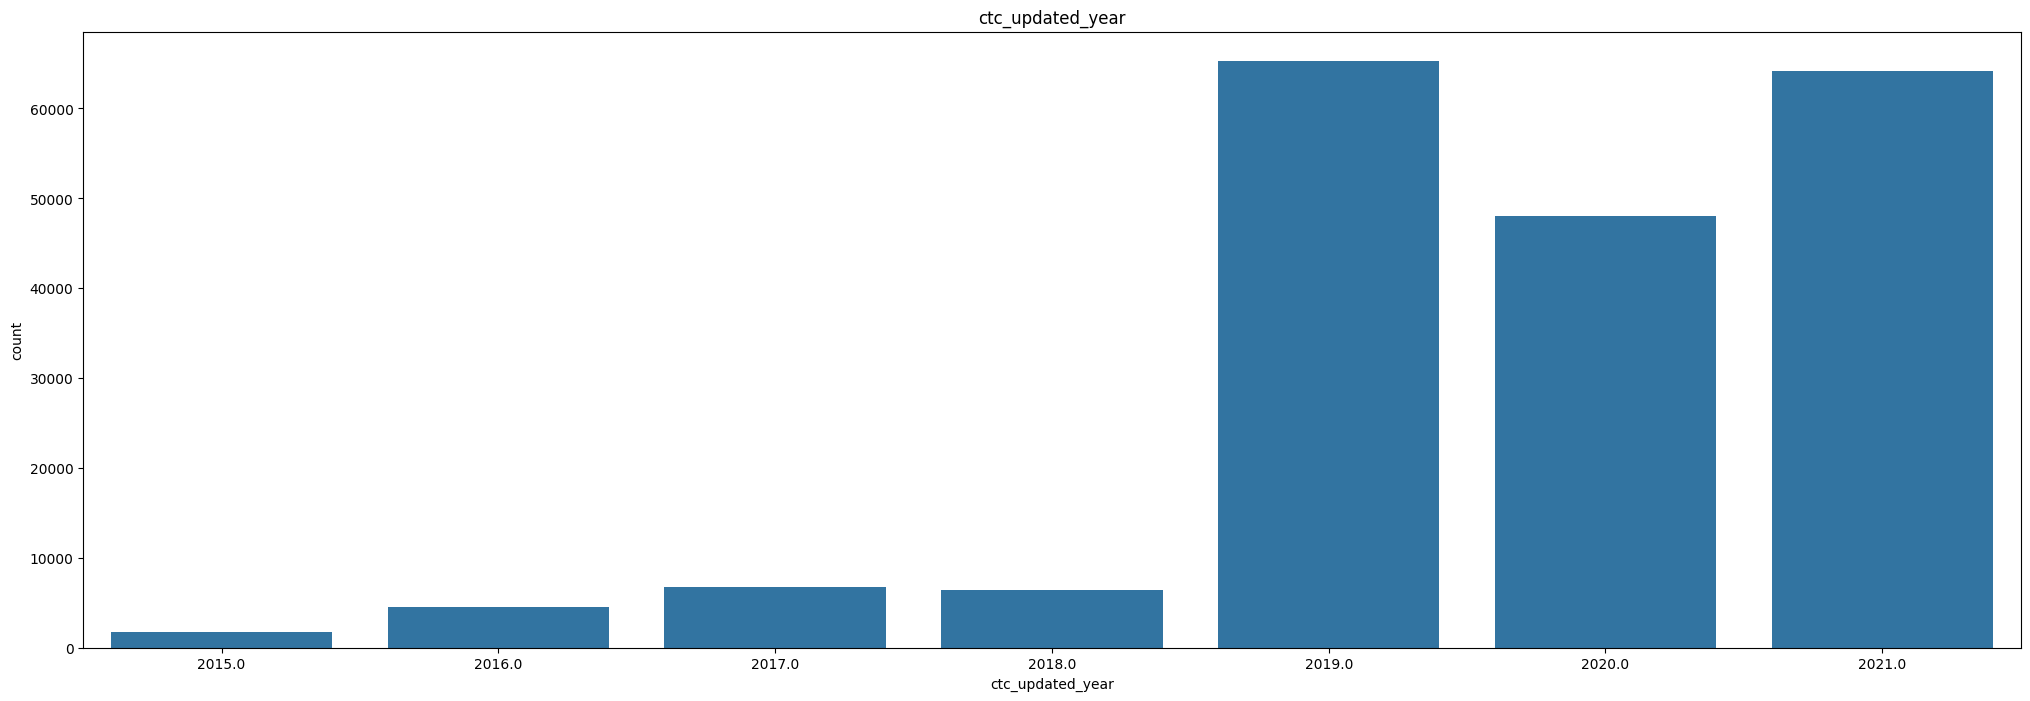

In [19]:
for i in categroical_columns:
    tmp = df_scaler.copy()
    tmp['count'] = 1
    tmp = tmp.groupby(i).sum()['count'].reset_index().sort_values('count',ascending=False).head(15)
    plt.figure(figsize=(25,8))
    sns.barplot(data=tmp,y='count',x=i).set(title=i)

    plt.show()

**Plotting Continuous Features**

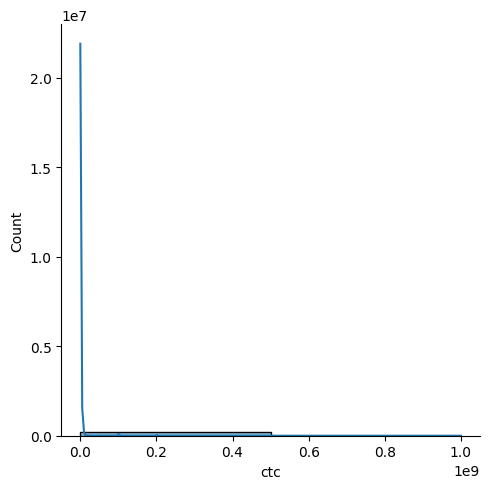

In [65]:
sns.displot(df_scaler['ctc'],kde=True,bins=2)
plt.show()

The plot seems to be having large range of values, let's try to scale column for visualizing.

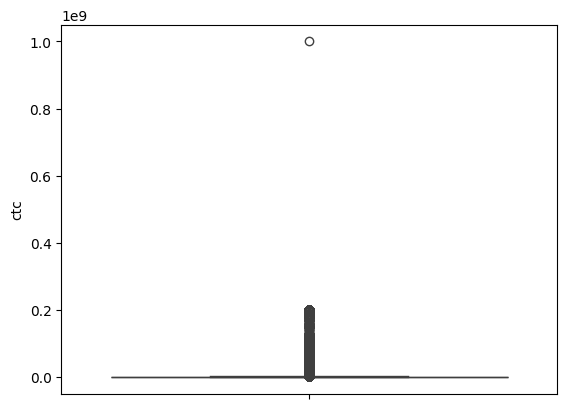

In [21]:
v = df_scaler['ctc']
#v = (v-v.mean())/v.std()
sns.boxplot(v)
plt.show()

In [22]:
df_scaler.sort_values(['ctc']).iloc[1000:1020,:]

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,orgyear_na,ctc_updated_year_na,company_hash_na,job_position_na,YoE,company_hash_encode,job_position_encode
44951,45004,Wgszxkvzn,F89Bed4006Cd071E35309E1C14F4619D347A9C614Eee22...,2015.0,12500,na,2019.0,False,False,False,True,4.0,0.015740,2553.548092
44901,44954,Wtznqt Egq Atctrgubtzn Ge Ntrtbvnxwo Wagn,09F5814Eaf7Ce72Ffbedc366132D57A887B0063C313201...,2018.0,12500,na,2019.0,False,False,False,True,1.0,0.000160,2553.548092
138199,138677,Grv Vzx Ntwyzgrgsxto Ucn Rna,De29A415707A4D86Bebdf3A3B262760B32D8373F748373...,2015.0,12500,Backend Engineer,2019.0,False,False,False,False,4.0,0.002074,2115.884436
70442,70541,Lxg,9Bc455A8507597F6C611129Ea9Faa67684828134D51Fda...,2018.0,12500,Backend Engineer,2019.0,False,False,False,False,1.0,0.000748,2115.884436
77316,77429,Ovu,De29A415707A4D86Bebdf3A3B262760B32D8373F748373...,2015.0,12500,Backend Engineer,2019.0,False,False,False,False,4.0,0.004285,2115.884436
224,224,Onvwpmgd,45B65D3Ff145D70A8007Da08A311Dc320E3418Dccbf83B...,2018.0,12600,FullStack Engineer,2019.0,False,False,False,False,1.0,0.000010,1200.769519
246,246,Btzngq Oxtbtzo Mhoxztoo,E95763Fc2A0Fed3F69F032253923E050Cc8A5A07D630Aa...,2017.0,12600,FullStack Engineer,2019.0,False,False,False,False,2.0,0.000010,1200.769519
247,247,Btzngq Oxtbtzo Mhoxztoo,E95763Fc2A0Fed3F69F032253923E050Cc8A5A07D630Aa...,2017.0,12600,Other,2019.0,False,False,False,False,2.0,0.000010,877.902090
166453,167171,Vctzht Wgat,42Eb4015053Ca905352455783Da195771C70Ac278E354E...,2018.0,12600,Backend Engineer,2018.0,False,False,False,False,0.0,0.000015,2115.884436
167060,167781,Rvbmav Owyggr,5C6Adf33F84B70B2C306F76Ddea1366Fdc30F794601205...,2020.0,12700,Engineering Leadership,2020.0,False,False,False,False,0.0,0.000019,333.749508


SInce there are lot of outliers we need to remove the some of them out of the inter quartile range.

In [23]:
dftmp = df_scaler.copy()
print(dftmp.shape)
cols = ['ctc'] # one or more

Q1 = dftmp[cols].quantile(0.25)
Q3 = dftmp[cols].quantile(0.75)
IQR = Q3 - Q1

dftmp = dftmp[~((dftmp[cols] < (Q1 - 1.5 * IQR)) |(dftmp[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(dftmp.shape)

(196952, 14)
(184499, 14)


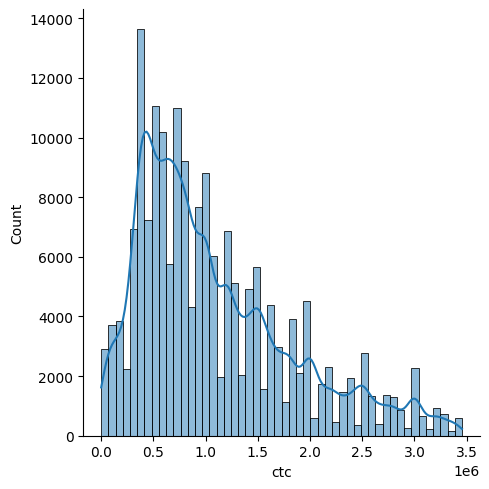

In [24]:
v = dftmp['ctc']
sns.displot(v,kde=True,bins=50)
plt.show()

**Boxplot after removing outliers**

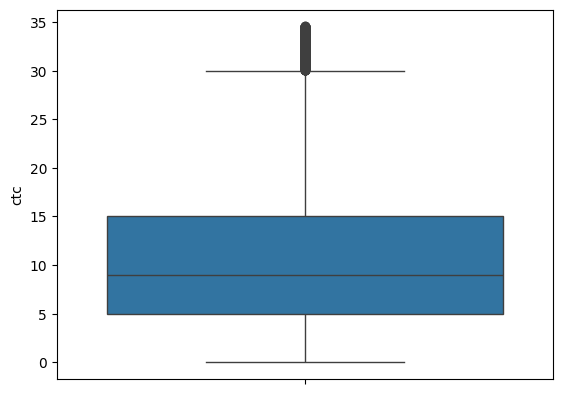

In [25]:
v = dftmp['ctc']/100000
#v = (v-v.mean())/v.std()
sns.boxplot(v)
plt.show()

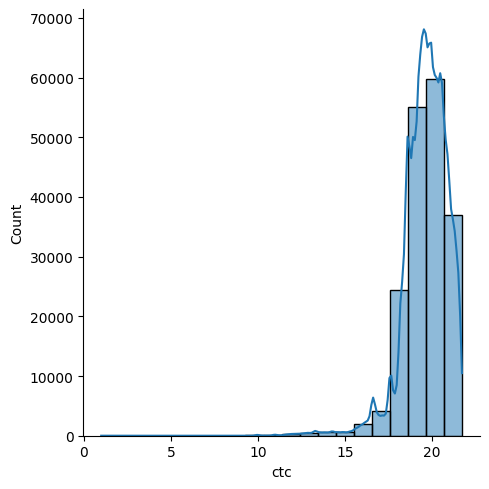

In [26]:
v = np.log2(dftmp['ctc'])
sns.displot(v,kde=True,bins=20)
plt.show()

**Multivariate Analysis**

Multivariate analysis involves examining the relationships and interdependencies among multiple variables simultaneously. It is used to understand how different variables influence each other and to identify patterns and trends in the data.

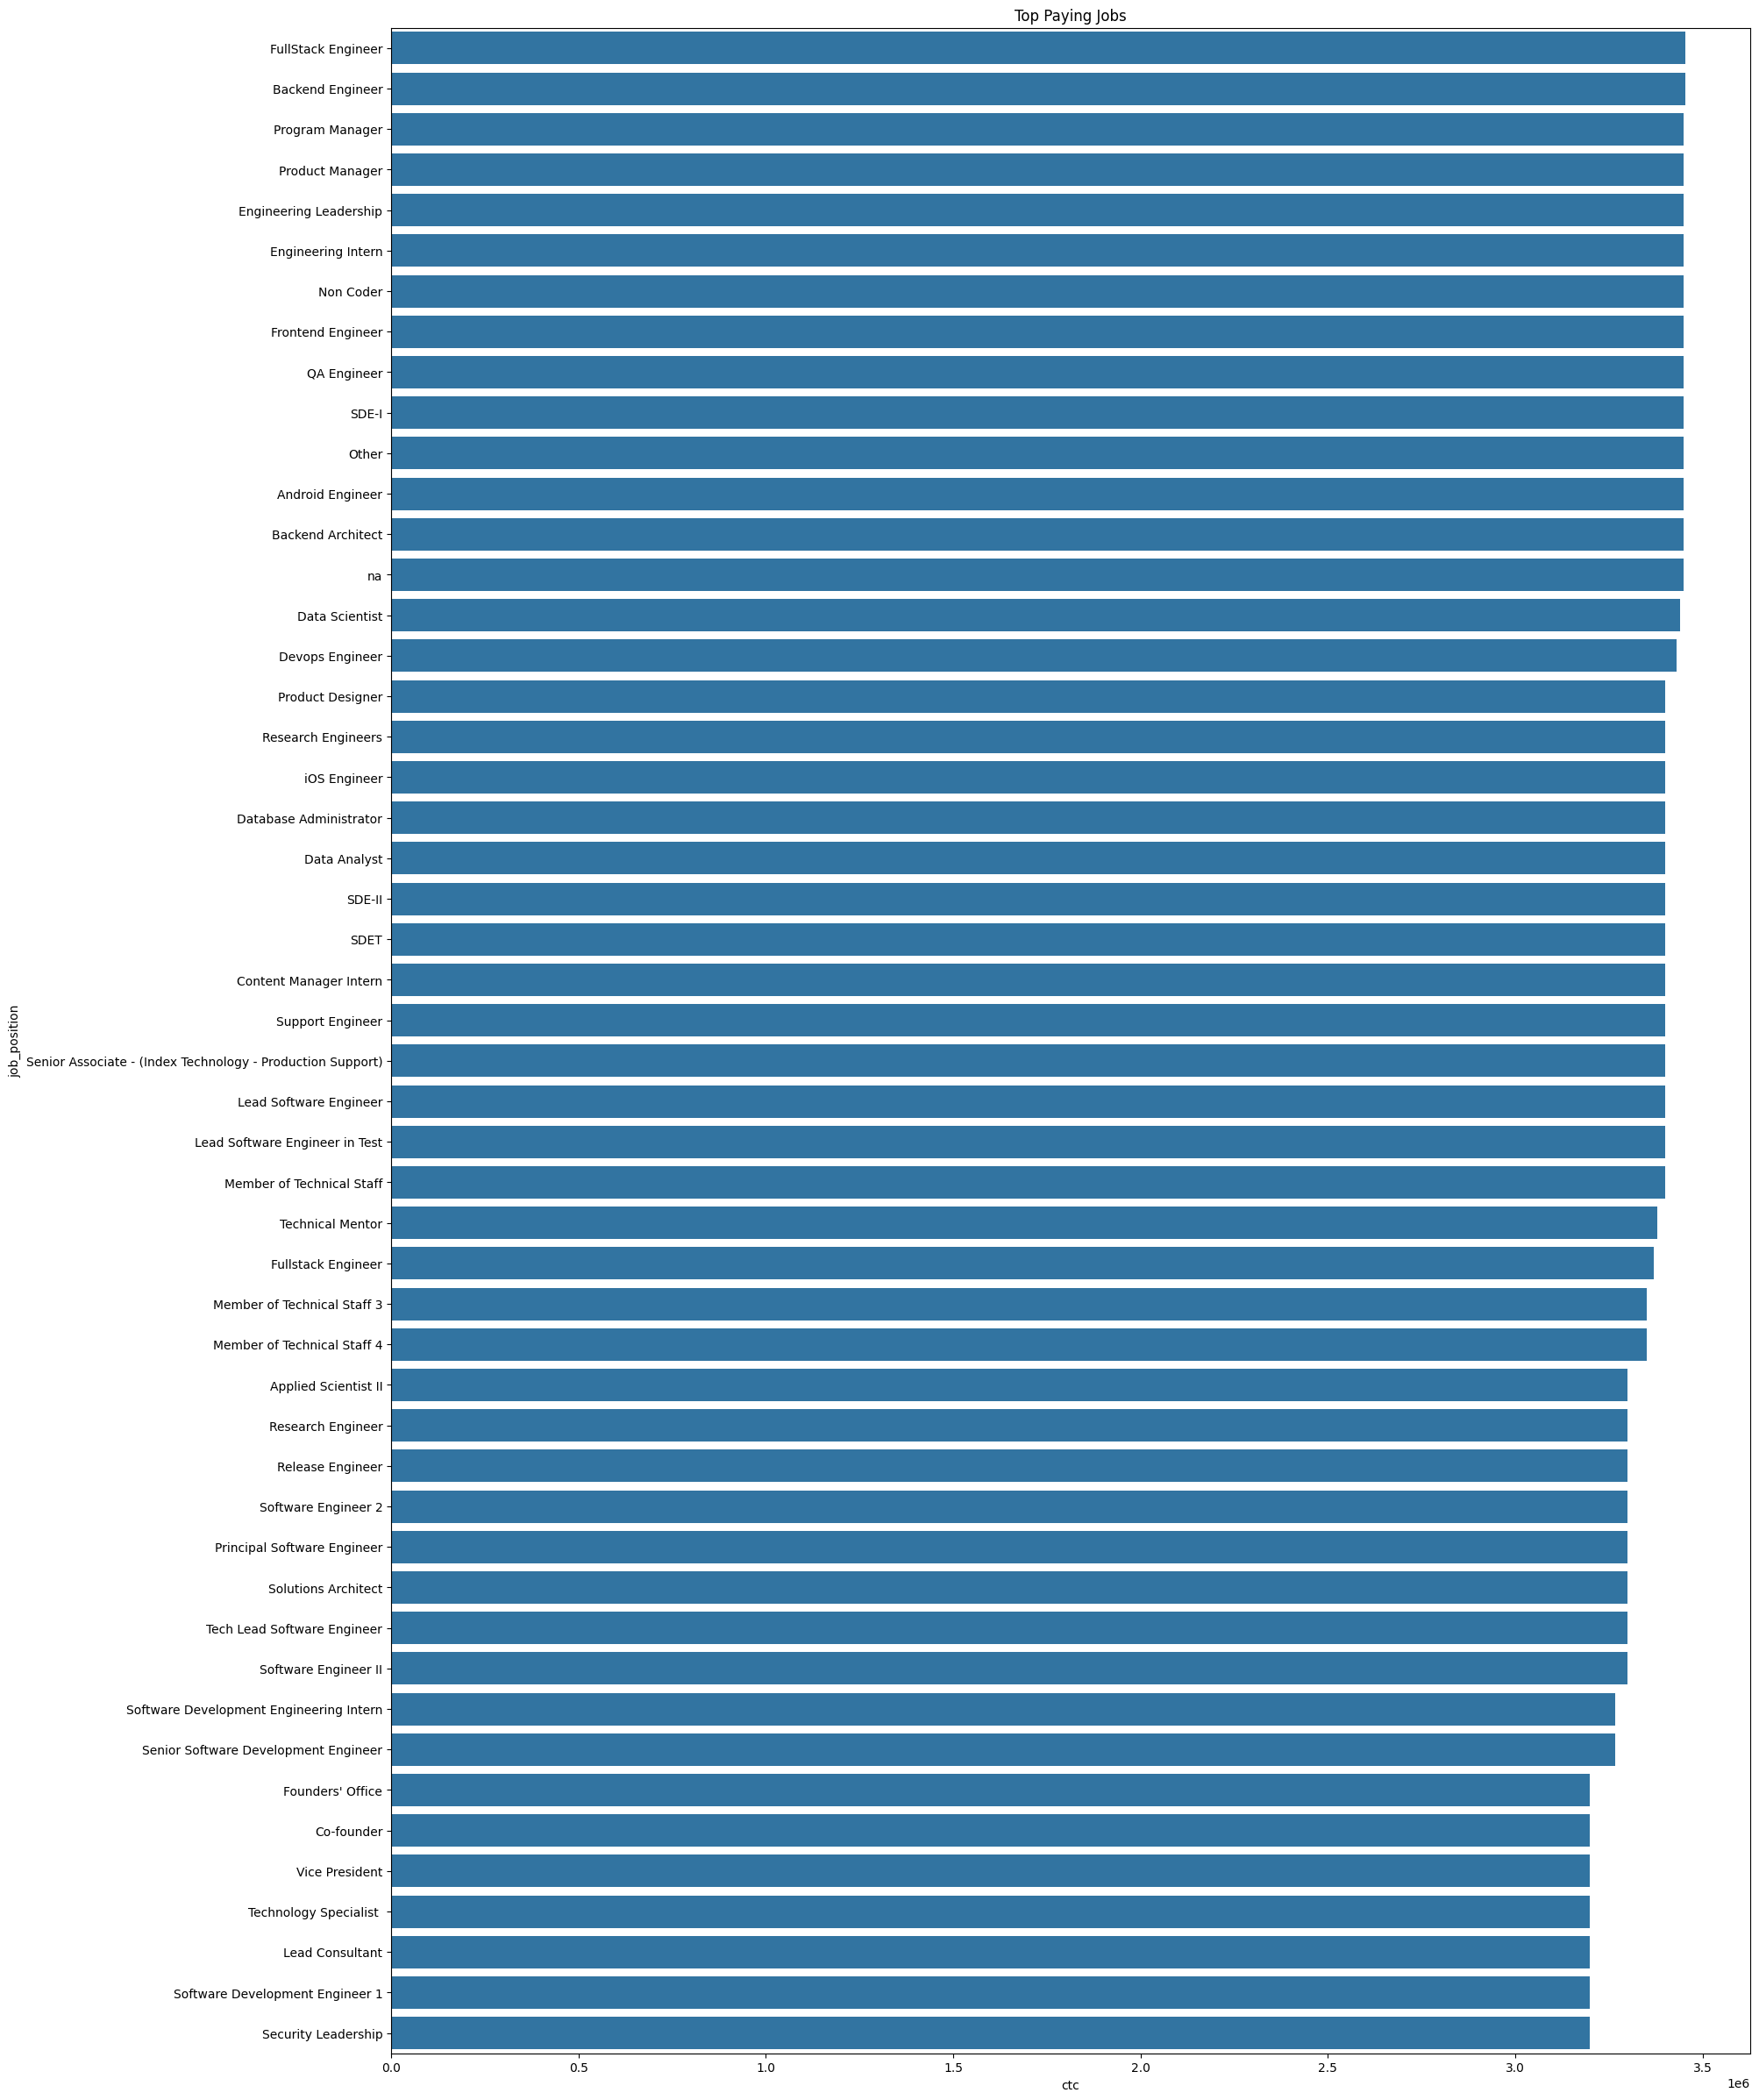

['FullStack Engineer',
 'Backend Engineer',
 'Program Manager',
 'Product Manager',
 'Engineering Leadership',
 'Engineering Intern',
 'Non Coder',
 'Frontend Engineer',
 'QA Engineer',
 'SDE-I',
 'Other',
 'Android Engineer',
 'Backend Architect',
 'na',
 'Data Scientist',
 'Devops Engineer',
 'Product Designer',
 'Research Engineers',
 'iOS Engineer',
 'Database Administrator',
 'Data Analyst',
 'SDE-II',
 'SDET',
 'Content Manager Intern',
 'Support Engineer',
 'Senior Associate - (Index Technology - Production Support)',
 'Lead Software Engineer',
 'Lead Software Engineer in Test',
 'Member of Technical Staff',
 'Technical Mentor',
 'Fullstack Engineer',
 'Member of Technical Staff 3',
 'Member of Technical Staff 4',
 'Applied Scientist II',
 'Research Engineer',
 'Release Engineer',
 'Software Engineer 2',
 'Principal Software Engineer',
 'Solutions Architect',
 'Tech Lead Software Engineer',
 'Software Engineer II',
 'Software Development Engineering Intern',
 'Senior Software De

In [27]:
tmp = dftmp.copy()
tmp = tmp.groupby(['job_position']).max()['ctc'].reset_index().sort_values('ctc',ascending=False).head(50)
plt.figure(figsize=(20,30))
sns.barplot(data=tmp,x='ctc',y='job_position').set(title="Top Paying Jobs")
plt.show()
list(tmp['job_position'])

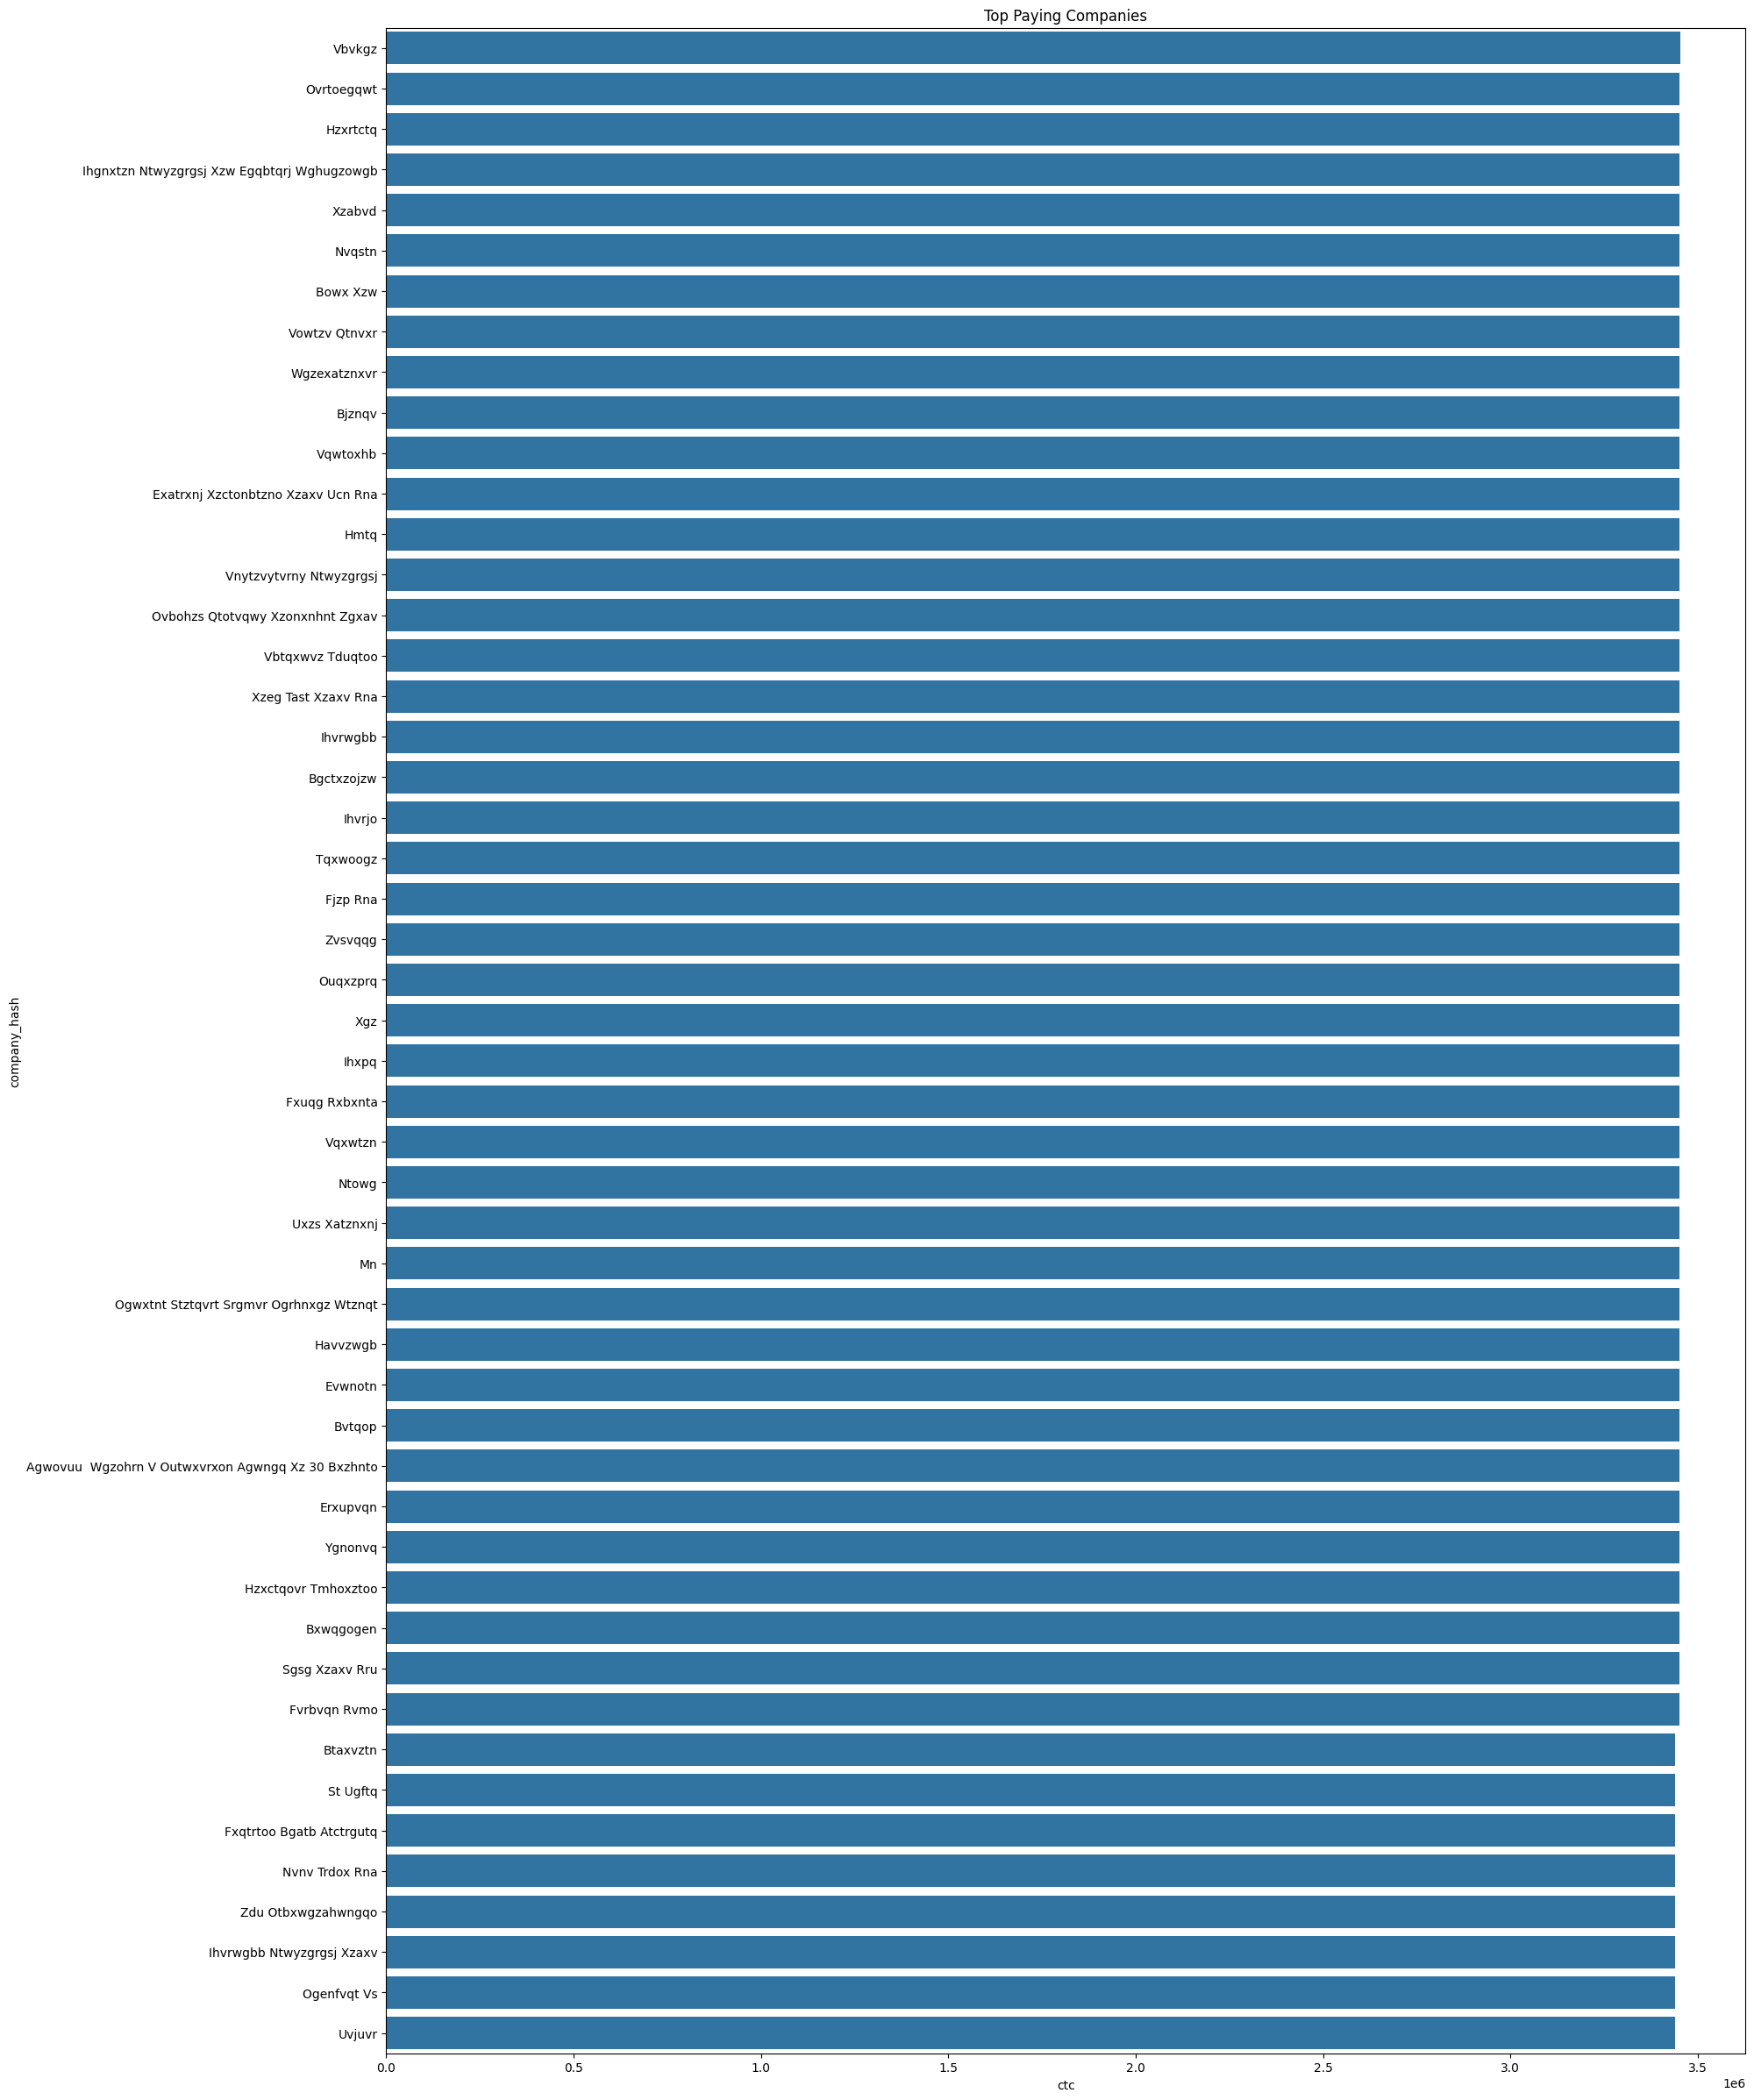

['Vbvkgz',
 'Ovrtoegqwt',
 'Hzxrtctq',
 'Ihgnxtzn Ntwyzgrgsj Xzw Egqbtqrj Wghugzowgb',
 'Xzabvd',
 'Nvqstn',
 'Bowx Xzw',
 'Vowtzv Qtnvxr',
 'Wgzexatznxvr',
 'Bjznqv',
 'Vqwtoxhb',
 'Exatrxnj Xzctonbtzno Xzaxv Ucn Rna',
 'Hmtq',
 'Vnytzvytvrny Ntwyzgrgsj',
 'Ovbohzs Qtotvqwy Xzonxnhnt Zgxav',
 'Vbtqxwvz Tduqtoo',
 'Xzeg Tast Xzaxv Rna',
 'Ihvrwgbb',
 'Bgctxzojzw',
 'Ihvrjo',
 'Tqxwoogz',
 'Fjzp Rna',
 'Zvsvqqg',
 'Ouqxzprq',
 'Xgz',
 'Ihxpq',
 'Fxuqg Rxbxnta',
 'Vqxwtzn',
 'Ntowg',
 'Uxzs Xatznxnj',
 'Mn',
 'Ogwxtnt Stztqvrt Srgmvr Ogrhnxgz Wtznqt',
 'Havvzwgb',
 'Evwnotn',
 'Bvtqop',
 'Agwovuu  Wgzohrn V Outwxvrxon Agwngq Xz 30 Bxzhnto',
 'Erxupvqn',
 'Ygnonvq',
 'Hzxctqovr Tmhoxztoo',
 'Bxwqgogen',
 'Sgsg Xzaxv Rru',
 'Fvrbvqn Rvmo',
 'Btaxvztn',
 'St Ugftq',
 'Fxqtrtoo Bgatb Atctrgutq',
 'Nvnv Trdox Rna',
 'Zdu Otbxwgzahwngqo',
 'Ihvrwgbb Ntwyzgrgsj Xzaxv',
 'Ogenfvqt Vs',
 'Uvjuvr']

In [28]:
tmp = dftmp.copy()
tmp = tmp.groupby(['company_hash']).max()['ctc'].reset_index().sort_values('ctc',ascending=False).head(50)
plt.figure(figsize=(20,30))
sns.barplot(data=tmp,x='ctc',y='company_hash').set(title="Top Paying Companies")
plt.show()

list(tmp['company_hash'])

<ipython-input-29-4116dc259c26>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby(['orgyear']).mean()['ctc'].reset_index().sort_values('ctc',ascending=False).head(50)


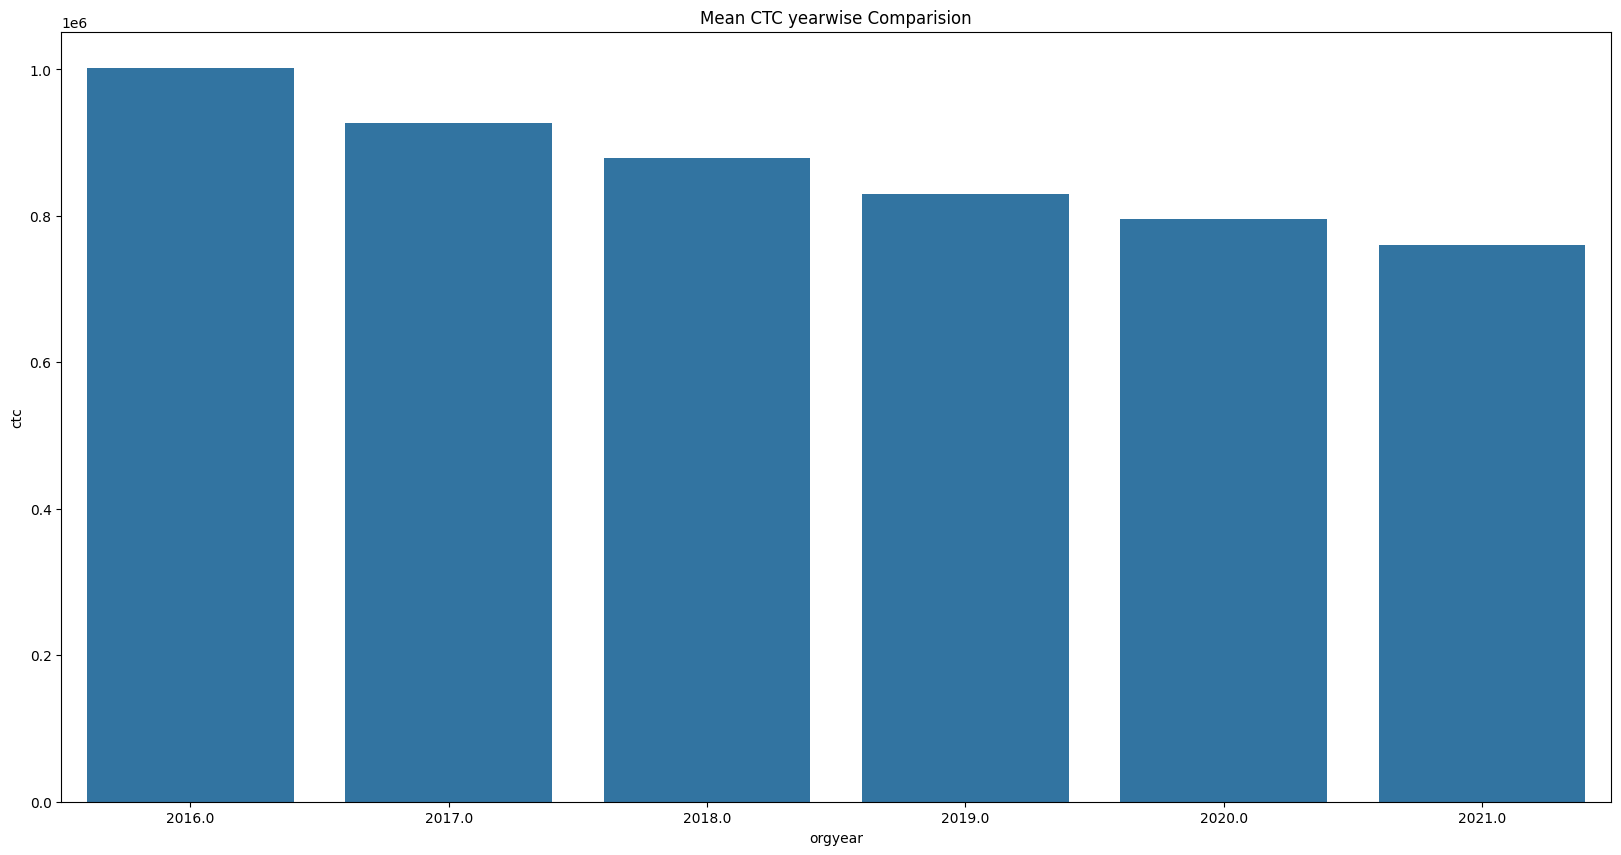

In [29]:
tmp = dftmp.copy()

tmp = tmp[tmp['orgyear'] >= 2016]
tmp = tmp.groupby(['orgyear']).mean()['ctc'].reset_index().sort_values('ctc',ascending=False).head(50)
plt.figure(figsize=(20,10))
sns.barplot(data=tmp,y='ctc',x='orgyear').set(title="Mean CTC yearwise Comparision")
plt.show()

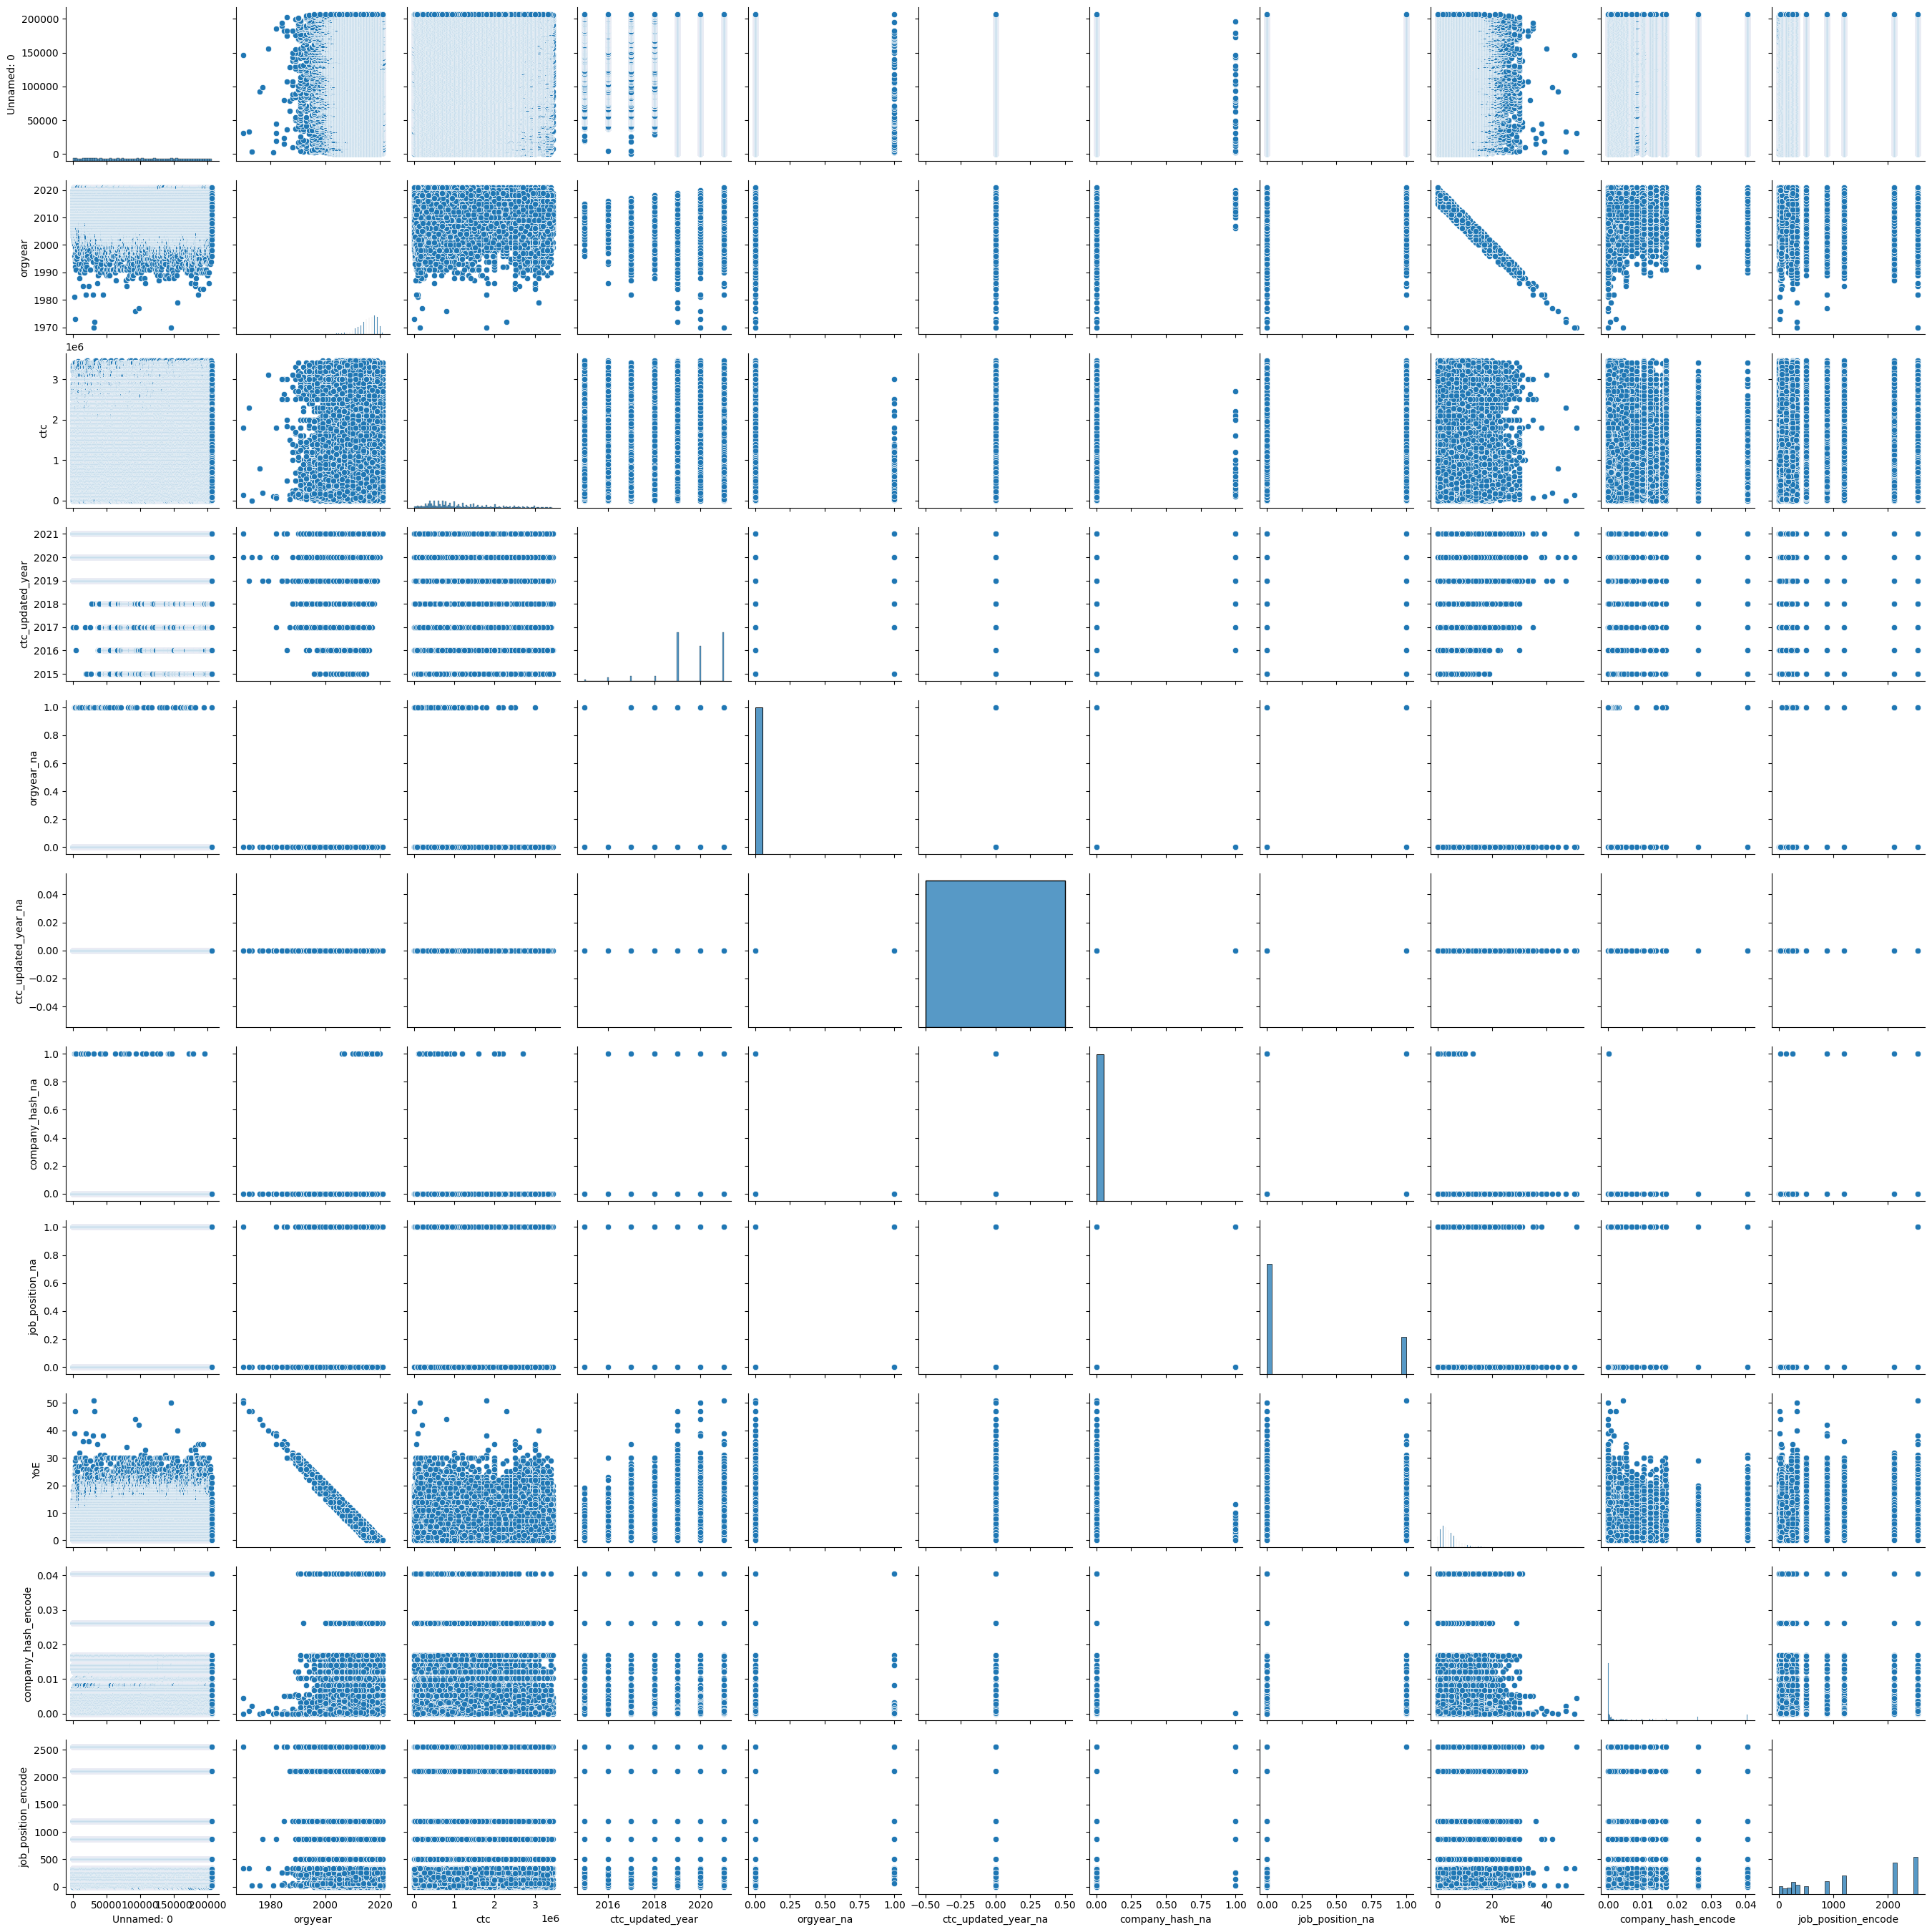

In [70]:
sns.pairplot(dftmp)

# **Manual Clustering**

Manual clustering is the process of assigning data points to clusters without using an algorithm. This can be done by visually inspecting the data and identifying natural groupings, or by using domain knowledge to assign data points to clusters.

Here are the steps involved in manual clustering:

**Data preparation:**

Clean and prepare the data for clustering.
This may involve removing outliers, scaling the data, or transforming the data into a more suitable format.
Exploratory data analysis:

Perform exploratory data analysis to understand the distribution of the data and identify potential clusters.
This can be done using various visualization techniques such as scatter plots, histograms, and box plots.

**Cluster identification:**

Visually inspect the data and identify natural groupings of data points.
This can be done by looking for patterns, similarities, or relationships between the data points.
Domain knowledge can also be used to identify clusters.

**Cluster assignment:**

Assign each data point to a cluster based on its similarity to other data points in the cluster.
This can be done manually or using a simple decision rule.

**Cluster validation:**

Evaluate the quality of the clusters using various cluster validation metrics such as silhouette coefficient, Calinski-Harabasz score, or Davies-Bouldin index.

This helps to ensure that the clusters are well-separated and meaningful.

In [30]:
dateda = dftmp.copy()

In [31]:
grp = ['company_hash','job_position','YoE']
data_tmp1 = dateda.groupby(grp).agg({'ctc':['mean','median','min','max','count']}).reset_index()
data_tmp1.columns  = ["{} {}".format(b_, a_) if a_ not in grp else "{}".format(a_) for a_, b_ in zip(data_tmp1.columns.droplevel(1), data_tmp1.columns.droplevel(0))  ]
data_tmp1.head(100).tail(50)

datatmp = dateda.merge(data_tmp1[['company_hash', 'job_position', 'YoE', 'mean ctc']],on=['company_hash', 'job_position', 'YoE'],how='left')



col1 = 'ctc'
col2 = 'mean ctc'
conditions  = [ datatmp[col1] > datatmp[col2], datatmp[col1] == datatmp[col2], datatmp[col1] < datatmp[col2] ]
choices     = [ 1, 2, 3 ]

datatmp['Designation'] = np.select(conditions, choices, default=np.nan)

In [32]:
grp = ['company_hash','job_position']
data_tmp1 = datatmp.groupby(grp).agg({'ctc':[('mean2','mean'),'median','min','max','count']}).reset_index()
data_tmp1.columns  = ["{} {}".format(b_, a_) if a_ not in grp else "{}".format(a_) for a_, b_ in zip(data_tmp1.columns.droplevel(1), data_tmp1.columns.droplevel(0))  ]
data_tmp1.head(100).tail(50)


datatmp = datatmp.merge(data_tmp1[grp + ['mean2 ctc']],on=grp,how='left')


col1 = 'ctc'
col2 = 'mean2 ctc'
conditions  = [ datatmp[col1] > datatmp[col2], datatmp[col1] == datatmp[col2], datatmp[col1] < datatmp[col2] ]
choices     = [ 1, 2, 3 ]

datatmp['Class'] = np.select(conditions, choices, default=np.nan)

In [33]:
grp = ['company_hash']
data_tmp1 = datatmp.groupby(grp).agg({'ctc':[('mean3','mean'),'median','min','max','count']}).reset_index()
data_tmp1.columns  = ["{} {}".format(b_, a_) if a_ not in grp else "{}".format(a_) for a_, b_ in zip(data_tmp1.columns.droplevel(1), data_tmp1.columns.droplevel(0))  ]
data_tmp1.head(100).tail(50)


datatmp = datatmp.merge(data_tmp1[grp + ['mean3 ctc']],on=grp,how='left')


col1 = 'ctc'
col2 = 'mean3 ctc'
conditions  = [ datatmp[col1] > datatmp[col2], datatmp[col1] == datatmp[col2], datatmp[col1] < datatmp[col2] ]
choices     = [ 1, 2, 3 ]

datatmp['Tier'] = np.select(conditions, choices, default=np.nan)

**Creating Designation Flag, Class Flag, Tier Flag**

In [34]:
datatmp['diff_desig'] = datatmp['ctc'] - datatmp['mean ctc']
datatmp['diff_class'] = datatmp['ctc'] - datatmp['mean2 ctc']
datatmp['diff_tier'] = datatmp['ctc'] - datatmp['mean3 ctc']

**Answering question based on manual clustering**

**Top 10 employees (earning more than most of the employees in the company) - Tier 1**

In [35]:
datatmp[datatmp['Tier'] == 1].sort_values('diff_tier',ascending=False).head(10)[['email_hash','ctc','mean3 ctc','diff_tier']]

,email_hash,ctc,mean3 ctc,diff_tier
122093,C41D6Ade244Ae41Bba47Acde9D69B67125409995Efea4C...,3300000,455712.315068,2.844288e+06
30974,Cb4Fd7C836570C3Dc14A64681C721Cd2E6F610F434E45D...,3400000,572304.958688,2.827695e+06
115664,7E1909A68606880Bb49E50198B85A8512F7F36Ecaac9A8...,3450000,649337.184851,2.800663e+06
166158,A6F2Fae941A508D1A2C270997D5F3689Ba6E6D7E20E1F9...,3400000,606287.925274,2.793712e+06
158717,2143575134Abe5B83E161A84Ad292935395F7C02646469...,3400000,606287.925274,2.793712e+06
135370,55467Bd49969Ee06436Da974Ce1Be4A71A0Ccf7603007E...,3400000,606287.925274,2.793712e+06
155745,73Cbc796A4302Bd691Bda6Ad9Da47Ec92F366Fb697869E...,3385000,691620.963613,2.693379e+06
41753,Ae7A452206D4A2639Ac928E17B6707A3E31D63695E075A...,3420000,751330.774229,2.668669e+06
20381,F29Cbd0F9E98F154A32Ebe5Fa74297A2439269Fea2Bbe5...,3420000,769515.887850,2.650484e+06
127090,B6Dbd61E6Ee883B59B80258Bd3B88170D6D6E903467208...,3400000,751330.774229,2.648669e+06


**Top 10 employees of data science earning more than their peers - Class 1**

In [36]:
datatmp[(datatmp['Tier'] == 1)&(datatmp['Class'] == 1)&(datatmp['job_position'].isin(['Data Science Analyst','Data Scientist','Data Scientist II','Associate Data Scientist','Senior Data Scientist']))].sort_values('diff_class',ascending=False).head(10)[['email_hash','ctc','mean2 ctc']]

,email_hash,ctc,mean2 ctc
47615,6Aa8Cfeb5B98Da66158E0Af4Ca8869362174Abdba84A02...,3200000,7.141405e+05
79513,4Cfa7E643B30A89189Bcca6084C9E273A9783E83Ad3B81...,2900000,7.141405e+05
175066,Ffe6E45B1B87424286Ea0E9E2F12891809A333B407F386...,3000000,8.256897e+05
120802,3Fb508Af01615Da04Ce4A8Faef1573797D752Ff1652Fac...,3300000,1.202333e+06
94716,Ba03144Eec86B2513986417E69648Ae8D9Ef8190Af2Bd2...,3100000,1.027382e+06
133262,5727Bd9467Ba7Fff71Afcbc88Ea2D71785Df377616B26F...,3429999,1.417654e+06
16635,75F4167C21F7525295831947F6112B2Ac1D34Accee21Ad...,3050000,1.075417e+06
48170,751B1Fb94F9054Ecc14B44Ebf91C3Cbd92A47Ea0194492...,3000000,1.026154e+06
53784,6C5D2A17Cb6C1Bb7Fad67E383E5Cc6C5De31895Dd31F6A...,3000000,1.027382e+06
82966,6Abeef8C169335Ba2A6466Cfa731A3C65899621C035Ea2...,3000000,1.102000e+06


**Bottom 10 employees of data science earning less than their peers - Class 3**

In [37]:
datatmp[(datatmp['Tier'] == 1)&(datatmp['Class'] == 3)&(datatmp['job_position'].isin(['Data Science Analyst','Data Scientist','Data Scientist II','Associate Data Scientist','Senior Data Scientist']))].sort_values('diff_class',ascending=True).head(10)[['email_hash','ctc','mean2 ctc']]

,email_hash,ctc,mean2 ctc
101264,2A3136F6E2D03A3Dbfa3F683E4Ae1B744B4815A8E0177C...,1700000,2.833333e+06
163712,F49Bd18E7Fe914929F6Cc23Bb4E7979D58290119F2Adcf...,1600000,2.500000e+06
135548,5F4B52A1C2539Fe2E4B29A8470Bc57Dbace331B819A0Af...,1440000,2.172500e+06
15350,A9Df781763832249D50A9E6Ce8C46Bd124525D38Ccc06E...,1100000,1.800000e+06
144989,D226Bd26C8743A649Fab3A6Bb17A3318Fd896C8B4Fd3F4...,1570000,2.257143e+06
60693,Dee5D8138D13267Ebfe5Dbd0Eb9A37860Bea9Caaf55F88...,1650000,2.330000e+06
17521,15A224659521108B95493Bafdc20655E78F9F5Db733817...,800000,1.425000e+06
80010,0723Dbae72Ae34Fb6B4B5Bf1A0A3Cef4751B545E63Ede9...,750000,1.338571e+06
24027,39502C33503D79F63588137846714450E7212D07D1F002...,1650000,2.225000e+06
128979,48Dbf039Fb89E2F32F2978068318D664D419Bc7B24Ae62...,1000000,1.550000e+06


**Bottom 10 employees (earning less than most of the employees in the company)- Tier 3**

In [38]:
datatmp[datatmp['Tier'] == 3].sort_values('diff_tier',ascending=True).head(10)[['email_hash','ctc','mean3 ctc']]

,email_hash,ctc,mean3 ctc
13885,Eb5Ba5Fab7Ef94B02820A9393Ede0924E26Fb2Ab5A7E65...,40000,2.334875e+06
48979,A2F9F60C141233C0B29Fbefe5Dcc80145C0047C7Cd040E...,200000,2.480000e+06
9289,9B2A2D65E11Ca456501Df1Af51Bd8384D7Cd76F6A02Ad0...,30000,2.286667e+06
67082,264722128F8Ee11132199Abc29Fee890C61Fdf7Dfefba7...,24000,2.246000e+06
122455,A62Ebbed17354Aeb3128Aff64427A7Dcb86E60043260Cf...,140000,2.334875e+06
41970,D0Fccf3Fd50744E63021F27A2B89F3Bd5Fc23E3F3F757E...,21000,2.193884e+06
110398,981767592C310822Be38C7Fa103807B2D6Da838Edc9B06...,26000,2.193884e+06
137237,981767592C310822Be38C7Fa103807B2D6Da838Edc9B06...,26000,2.193884e+06
33838,4Ee3Afc30920186D15D98Cf407E1059Ee8C3D8E3Cdaffc...,19700,2.178635e+06
88451,4Ee3Afc30920186D15D98Cf407E1059Ee8C3D8E3Cdaffc...,19700,2.178635e+06


**Top 10 employees having 5/6/7 years of experience earning more than their peers - Tier X**

In [40]:
datatmp[(datatmp['YoE'].isin([5.0,6.0,7.0]))].sort_values('diff_desig',ascending=False).head(10)[['email_hash','ctc','mean ctc']]

,email_hash,ctc,mean ctc
9754,F982608395D7209Dff7D8F19Af2Bdb0E1256240107Bd46...,3220000,6.333333e+05
615,F982608395D7209Dff7D8F19Af2Bdb0E1256240107Bd46...,3220000,6.718367e+05
127090,B6Dbd61E6Ee883B59B80258Bd3B88170D6D6E903467208...,3400000,9.503333e+05
19270,1Fda9E5Caa80Bb0D96F4172Eeeb7A2E33B6D25Cf0C4964...,3200000,7.993570e+05
161213,248592Aa59Bfab5Bf6Bd99788Ae4E9Ede8E4A6Fd1B5A99...,3300000,9.482352e+05
126246,308Cf4F716697C7C5A5534958726F61Cba1Bede17Ded86...,3000000,7.172500e+05
81708,7A8607A37Ffb823E01E81E5B0F77Ef08Fd6Fdfc8A1D865...,3300000,1.045000e+06
152350,C5B16Ad982Ca39De374D8F34D3Cea8373Fae83Bebe169D...,3080000,8.858333e+05
32958,5491Ebb4385F4D135E79Ecd253Eda3753D75F262F001Dd...,3000000,8.478764e+05
106522,525Bb6B98A6Fb8Aa1060A2Dbcf39405B1873Aa58D15Cef...,3000000,8.858333e+05


**Top 10 companies (based on their CTC)**

In [41]:
datatmp.groupby('company_hash').mean()['ctc'].reset_index().sort_values('ctc',ascending=False).head(10)[['company_hash','ctc']]

<ipython-input-41-e252ba0d71bd>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datatmp.groupby('company_hash').mean()['ctc'].reset_index().sort_values('ctc',ascending=False).head(10)[['company_hash','ctc']]


,company_hash,ctc
31137,Xzabvd,3450000.0
19996,Sgsg Xzaxv Rru,3450000.0
8248,Ihgnxtzn Ntwyzgrgsj Xzw Egqbtqrj Wghugzowgb,3450000.0
5736,Exatrxnj Xzctonbtzno Xzaxv Ucn Rna,3450000.0
8031,Hzxctqovr Tmhoxztoo,3450000.0
12570,Nvnv Trdox Rna,3440000.0
6660,Fxqtrtoo Bgatb Atctrgutq,3440000.0
8369,Ihvrwgbb Ntwyzgrgsj Xzaxv,3440000.0
10754,Mvzp Ge Vbtqxwv Yjatqvmva,3429999.0
2637,Btqwtato Mtzk Qtotvqwy Vza Atctrgubtzn Wtzntq,3429999.0


**Top 2 positions in every company (based on their CTC)**

In [42]:
tmp = datatmp[datatmp['job_position'] != 'na']
tmp = tmp.groupby(['company_hash','job_position']).mean().sort_values(['company_hash','ctc']).reset_index()
tmp = tmp.groupby('company_hash').head(2)[['company_hash','job_position']]
tmp

<ipython-input-42-ef234a50487a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby(['company_hash','job_position']).mean().sort_values(['company_hash','ctc']).reset_index()


,company_hash,job_position
0,0,Other
1,0000,Other
2,01 Ojztqsj,Android Engineer
3,01 Ojztqsj,Frontend Engineer
4,05Mz Exzytvrny Uqxcvnt Rxbxnta,Backend Engineer
...,...,...
54711,Zyuw Rxbxnta,Frontend Engineer
54712,Zyvzwt Wgzohrnxzs Tzsxzttqo,Frontend Engineer
54713,Zz,Other
54714,Zzb Ztdnstz Vacxogqj Ucn Rna,FullStack Engineer


**Preparing data for training model(Imputation/Scaling)**

We are creating a copy of the data for further scaling purpose.

In [43]:
data_scaler = dateda.copy()
data_scaler

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,orgyear_na,ctc_updated_year_na,company_hash_na,job_position_na,YoE,company_hash_encode,job_position_encode
0,0,Atrgxnnt Xzaxv,6De0A4417D18Ab14334C3F43397Fc13B30C35149D70C05...,2016.0,1100000,Other,2020.0,False,False,False,False,4.0,0.000044,877.902090
1,1,Qtrxvzwt Xzegwgbb Rxbxnta,B0Aaf1Ac138B53Cb6E039Ba2C3D6604A250D02D5145C10...,2018.0,449999,FullStack Engineer,2019.0,False,False,False,False,1.0,0.002084,1200.769519
2,2,Ojzwnvwnxw Vx,4860C670Bcd48Fb96C02A4B0Ae3608Ae6Fdd98176112E9...,2015.0,2000000,Backend Engineer,2020.0,False,False,False,False,5.0,0.000005,2115.884436
3,3,Ngpgutaxv,Effdede7A2E7C2Af664C8A31D9346385016128D66Bbc58...,2017.0,700000,Backend Engineer,2019.0,False,False,False,False,2.0,0.000340,2115.884436
4,4,Qxen Sqghu,6Ff54E709262F55Cb999A1C1Db8436Cb2055D8F79Ab520...,2017.0,1400000,FullStack Engineer,2019.0,False,False,False,False,2.0,0.000029,1200.769519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205837,206917,Zgn Vuurxwvmrt,Fe34477C3F64E6Ed4301417C8Fb9D5E2608722A10F1F4E...,2021.0,800000,na,2021.0,False,False,False,True,0.0,0.005213,2553.548092
205838,206918,Vuurt Xzw,70027B728C8Ee901Fe979533Ed94Ffda97Be08Fc23F33B...,2008.0,220000,na,2019.0,False,False,False,True,11.0,0.000083,2553.548092
205839,206919,Husqvawgb,7F7292Ffad724Ebbe9Ca860F515245368D714C84705B42...,2017.0,500000,na,2020.0,False,False,False,True,3.0,0.000525,2553.548092
205840,206920,Vwwgrxnt,Cb25Cc7304E9A24Facda7F5567C7922Ffc48E3D5D6018C...,2021.0,700000,na,2021.0,False,False,False,True,0.0,0.000821,2553.548092


**Transforming ctc feature using log function**

There are several reasons why transforming a column using the log function can be useful:

**Feature scaling:**

The log function can be used as a feature scaling technique for machine learning algorithms. This can help to improve the performance of the algorithms by ensuring that all features are on a similar scale.

**Normalizing skewed data:**

The log function can be used to normalize skewed data, making it more symmetrical and closer to a normal distribution. This can be helpful for various statistical analyses and machine learning algorithms that assume normality.

**Compressing the range of values:**

The log function can compress the range of values in a column, making it easier to visualize and interpret the data. This can be particularly useful for columns with large variations in values.

**Stabilizing variance:**

The log function can stabilize the variance of a column, making it less sensitive to outliers. This can be important for certain statistical analyses and machine learning algorithms that are sensitive to variance.

**Dealing with multiplicative relationships:**

The log function can transform multiplicative relationships into additive relationships. This can be helpful for certain statistical analyses and machine learning algorithms that are better suited for additive relationships.



In [44]:
data_scaler['ctc_log'] = np.log2(data_scaler['ctc'])

Columns like ['normalized_company_name','job_position','email_hash','Unnamed: 0','company'] are text.
We can't use them during imputation, so we'll remove these columns

In [45]:
drop_cols = ['normalized_company_name','job_position','email_hash','Unnamed: 0','company_hash']
for i in drop_cols:
    try:
        data_scaler.drop([i],axis=1,inplace=True)
    except:
        print('no')

no


In [46]:
data_scaler.columns

Index(['orgyear', 'ctc', 'ctc_updated_year', 'orgyear_na',
       'ctc_updated_year_na', 'company_hash_na', 'job_position_na', 'YoE',
       'company_hash_encode', 'job_position_encode', 'ctc_log'],
      dtype='object')

# **Training Model**

In [47]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# **Kmeans clustering**

K-means clustering is a method of cluster analysis that aims to partition a data set into k clusters, where k is a user-specified number. The goal of k-means clustering is to minimize the sum of squared distances between each data point and its assigned cluster centroid.

**Steps in K-means Clustering:**

Initialize the cluster centroids. This can be done randomly or by selecting k data points from the data set.

Assign each data point to the cluster with the nearest centroid.

Recalculate the cluster centroids.

Repeat steps 2 and 3 until the cluster centroids no longer change.

In [48]:
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn_imputer',  KNNImputer(n_neighbors=2, weights="uniform"))])
pipe_knn_5 = Pipeline([('scaler', StandardScaler()), ('knn_imputer',  KNNImputer(n_neighbors=5, weights="uniform"))])
pipe = Pipeline([('scaler', StandardScaler()), ('simple_imputer',  SimpleImputer(missing_values=np.nan, strategy='mean'))])
pipe_knn_pca = Pipeline([('scaler', StandardScaler()), ('knn_imputer',  KNNImputer(n_neighbors=2, weights="uniform")),('pca',PCA(n_components=8))])
pipe_unscaled = Pipeline([('knn_imputer',  KNNImputer(n_neighbors=5, weights="uniform"))])

In [49]:
data_scaler.head()

,orgyear,ctc,ctc_updated_year,orgyear_na,ctc_updated_year_na,company_hash_na,job_position_na,YoE,company_hash_encode,job_position_encode,ctc_log
0,2016.0,1100000,2020.0,False,False,False,False,4.0,0.000044,877.902090,20.069072
1,2018.0,449999,2019.0,False,False,False,False,1.0,0.002084,1200.769519,18.779562
2,2015.0,2000000,2020.0,False,False,False,False,5.0,0.000005,2115.884436,20.931569
3,2017.0,700000,2019.0,False,False,False,False,2.0,0.000340,2115.884436,19.416995
4,2017.0,1400000,2019.0,False,False,False,False,2.0,0.000029,1200.769519,20.416995


**Finding optimal num of clusters using Elbow method**

**Elbow method:**

The elbow method is a method for determining the optimal number of clusters in a data set using hierarchical clustering. It involves plotting the distortion score for each possible number of clusters and then choosing the number of clusters where the distortion score starts to increase significantly.

The distortion score is a measure of how well the data points are clustered. It is calculated as the sum of the squared distances between each data point and its assigned cluster centroid.

Running for  KNN Immputation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

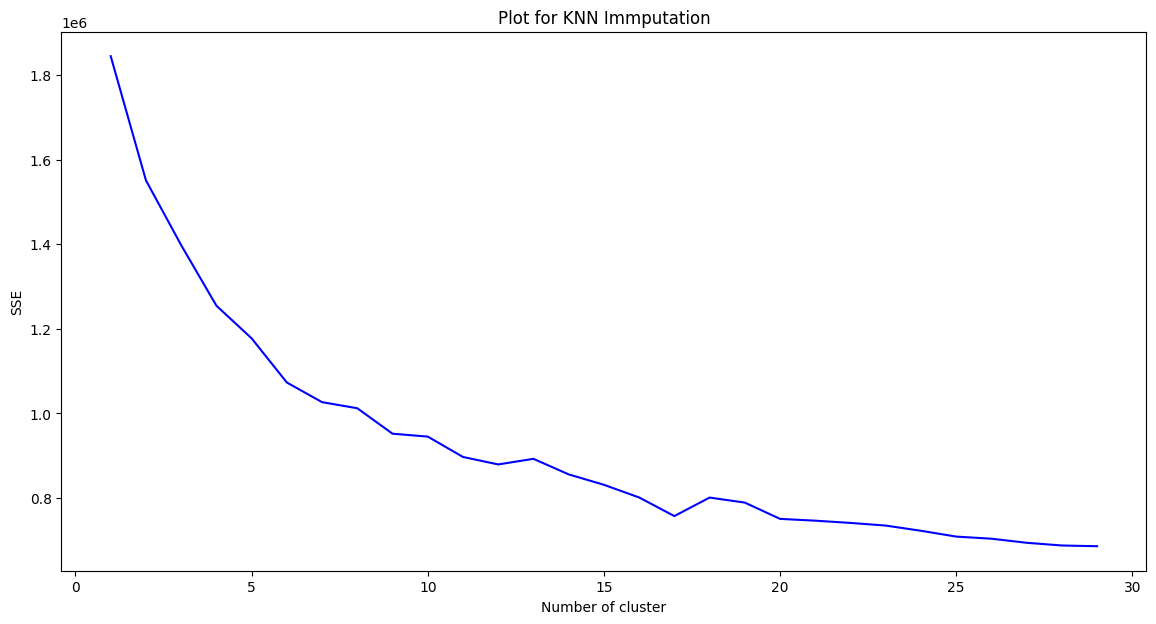

Running for  KNN Imputation with (default) 5 neighbours


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

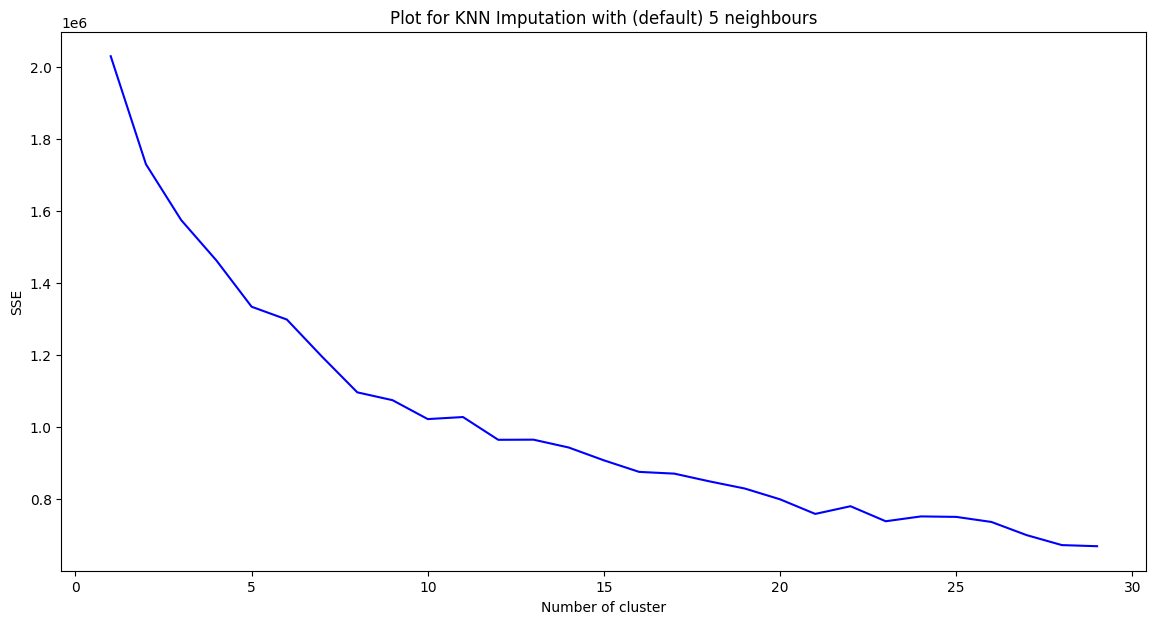

Running for  Mean Imputation 


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

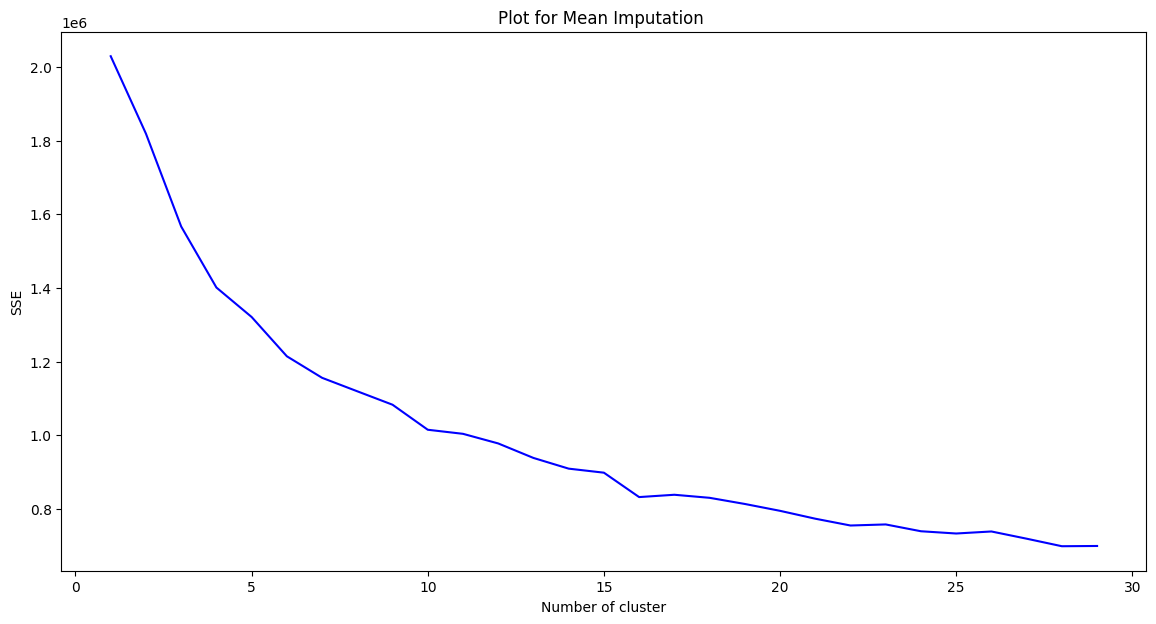

Running for  KNN Immputation + PCA


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

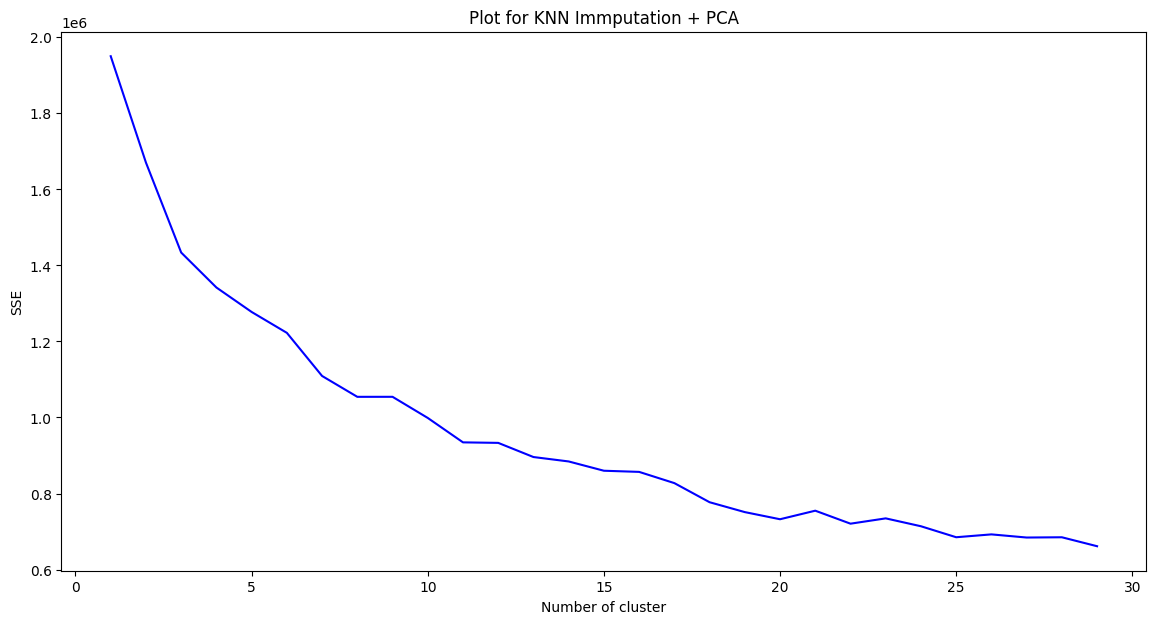

Running for  KNN Imputation Unscaled data_scaler


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

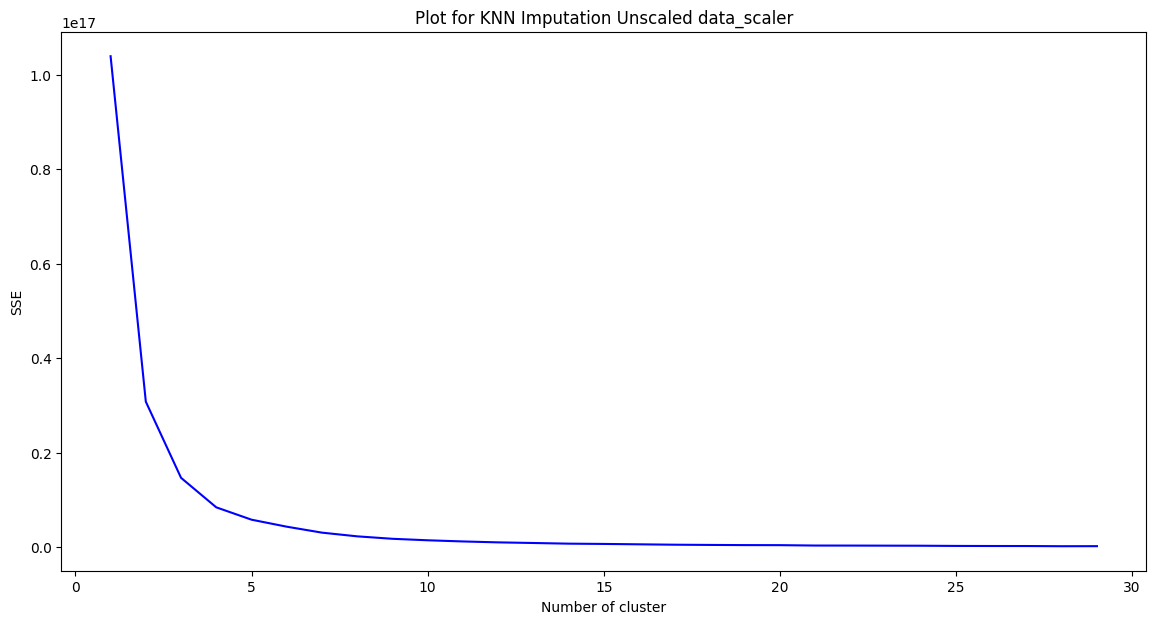

In [50]:
for name,pipeline in [('KNN Immputation',pipe_knn),('KNN Imputation with (default) 5 neighbours',pipe_knn_5),('Mean Imputation ',pipe),
                      ('KNN Immputation + PCA', pipe_knn_pca),('KNN Imputation Unscaled data_scaler',pipe_unscaled )]:

    X = pipeline.fit_transform(data_scaler)
    X = pd.DataFrame(X)
    if "PCA" not in name :
        X.columns= data_scaler.columns

    sse = {}
    #sil_score = {}
    print("Running for ",name)
    for k in range(1, 30):
        #print('K :',k)
        kmeans = MiniBatchKMeans(init="k-means++",n_clusters=k,
                              random_state=0).fit(X)
        label = kmeans.labels_
        data_scaler["clusters"] = label
        #print(data_scaler["clusters"])
        sse[k] = kmeans.inertia_

        #sil_score[k] = silhouette_score(X, label, metric='euclidean')

    plt.figure(figsize=(14,7))
    plt.plot(list(sse.keys()), list(sse.values()),'b-',label='Sum of squared error')
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.title("Plot for "+name)
    plt.show()

Insights:

    Model	                                  n_clusters

KNN Immputation	                                16

KNN Imputation with (default) 5 neighbours	    20

Mean Imputation	                                25

KNN Immputation + PCA	                          21

KNN Imputation Unscaled data	                  5

Number of clusters is around 16-20 for scaled data, while around 5 for unscaled data

# **Hierarchical Clustering**

Hierarchical clustering is a method of cluster analysis that seeks to build a hierarchy of clusters. It starts with each data point as a separate cluster and then iteratively merges the closest clusters until all data points are in a single cluster.

There are two main types of hierarchical clustering:

**Agglomerative clustering**: This is the most common type of hierarchical clustering. It starts with each data point as a separate cluster and then iteratively merges the closest clusters until all data points are in a single cluster.

**Divisive clustering**: This type of hierarchical clustering starts with all data points in a single cluster and then iteratively splits the cluster into smaller clusters until each data point is in its own cluster.



In [51]:
data_scaler.head()

,orgyear,ctc,ctc_updated_year,orgyear_na,ctc_updated_year_na,company_hash_na,job_position_na,YoE,company_hash_encode,job_position_encode,ctc_log,clusters
0,2016.0,1100000,2020.0,False,False,False,False,4.0,0.000044,877.902090,20.069072,13
1,2018.0,449999,2019.0,False,False,False,False,1.0,0.002084,1200.769519,18.779562,3
2,2015.0,2000000,2020.0,False,False,False,False,5.0,0.000005,2115.884436,20.931569,11
3,2017.0,700000,2019.0,False,False,False,False,2.0,0.000340,2115.884436,19.416995,24
4,2017.0,1400000,2019.0,False,False,False,False,2.0,0.000029,1200.769519,20.416995,21


In [52]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [53]:
data_scaler.isna().sum()

orgyear                78
ctc                     0
ctc_updated_year        0
orgyear_na              0
ctc_updated_year_na     0
company_hash_na         0
job_position_na         0
YoE                    78
company_hash_encode     0
job_position_encode     0
ctc_log                 0
clusters                0
dtype: int64

In [54]:
data_scaler['orgyear'].unique()

array([2016., 2018., 2015., 2017., 2019., 2020., 2012., 2013., 2003.,
       2006., 2014., 2011., 2008., 2004., 2009., 2005., 2010., 2007.,
       2021., 2002., 2001., 1981.,   nan, 1996., 2000., 1999., 1997.,
       1994., 1995., 1992., 1973., 1991., 1998., 1993., 1988., 1990.,
       1985., 1982., 1970., 1972., 1986., 1989., 1987., 1976., 1977.,
       1979., 1984.])

In [55]:
data_scaler.shape

(184499, 12)

Since no of records with nan is too less we will be removing them

In [56]:
data_scaler_cleaned = data_scaler.dropna(subset=['orgyear','YoE'])

In [57]:
data_scaler_cleaned.isna().sum()

orgyear                0
ctc                    0
ctc_updated_year       0
orgyear_na             0
ctc_updated_year_na    0
company_hash_na        0
job_position_na        0
YoE                    0
company_hash_encode    0
job_position_encode    0
ctc_log                0
clusters               0
dtype: int64

In order to perform Agglomerative clustering over the given dataset on Google colab, we neeed to reduce the dataset so that it takes lesser RAM.

There are two main types of linkage in agglomerative clustering:

**1. Single linkage:**

Also called nearest neighbor linkage.
The distance between two clusters is defined as the distance between their two closest data points.
Sensitive to outliers.

Can produce elongated clusters.

**2. Complete linkage:**

Also called furthest neighbor linkage.
The distance between two clusters is defined as the distance between their two furthest data points.

Less sensitive to outliers than single linkage.

Can produce more compact clusters than single linkage.

Other types of linkage:

**Average linkage**: The distance between two clusters is defined as the average distance between all pairs of data points from the two clusters.

**Centroid linkage**: The distance between two clusters is defined as the distance between their two centroids.

**Ward's method**: A variant of centroid linkage that minimizes the variance of the clusters at each step.

In [58]:
data_scaler_cleaned.shape

(184421, 12)

In [59]:
data_scaler_cleaned = data_scaler_cleaned[0:int(20000/2)]

In [60]:
data_scaler_cleaned.shape

(10000, 12)

**Dendrogram:**

A dendrogram is a tree-like diagram that shows the hierarchy of clusters in a hierarchical clustering. It is created by plotting the distances between clusters at each level of the hierarchy.

The root of the dendrogram represents the single cluster that contains all of the data points. The leaves of the dendrogram represent the individual data points. The branches of the dendrogram represent the merging of clusters at each level of the hierarchy.

The height of a branch in the dendrogram represents the distance between the two clusters that are being merged. The longer the branch, the greater the distance between the clusters.

To find the number of clusters from a dendrogram:

Draw a horizontal line across the dendrogram at the desired level of similarity.

Count the number of vertical lines that the horizontal line intersects.

This number represents the number of clusters present in the data.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster Labels: [0 0 0 ... 0 0 0]


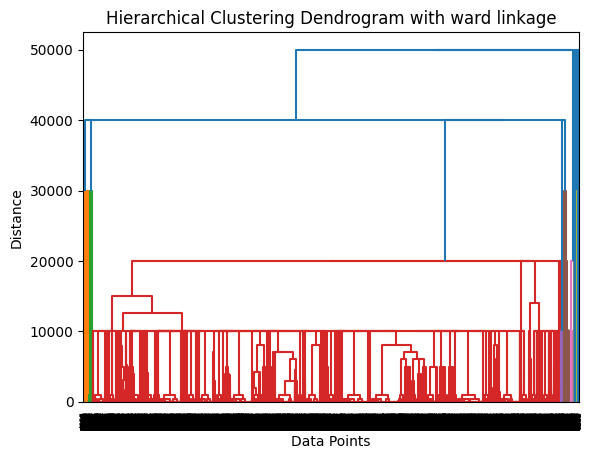

In [67]:
# Perform hierarchical clustering using AgglomerativeClustering with Single linkage
# You can adjust the number of clusters and linkage type as needed
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='single')
cluster_labels = clustering.fit_predict(data_scaler_cleaned)

# Print cluster assignments
print("Cluster Labels:", cluster_labels)

# Plot dendrogram for visualization
linkage_matrix = linkage(data_scaler_cleaned, 'single')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram with Single linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

**Insight:**

There seems to be too many clusters formed for single linkage AgglomerativeClustering. This makes it difficult to for us to find the number of clusters.

For Single Linkage the number of clusters seems to 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster Labels: [0 0 2 ... 0 0 0]


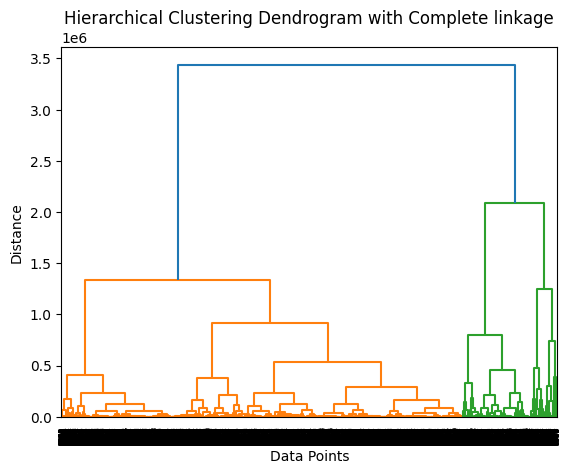

In [69]:
# Perform hierarchical clustering using AgglomerativeClustering with Complete linkage
# You can adjust the number of clusters and linkage type as needed
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')
cluster_labels = clustering.fit_predict(data_scaler_cleaned)

# Print cluster assignments
print("Cluster Labels:", cluster_labels)

# Plot dendrogram for visualization
linkage_matrix = linkage(data_scaler_cleaned, 'complete')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram with Complete linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


For Complete Linkage the number of clusters seems to be 2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster Labels: [0 0 1 ... 0 0 0]


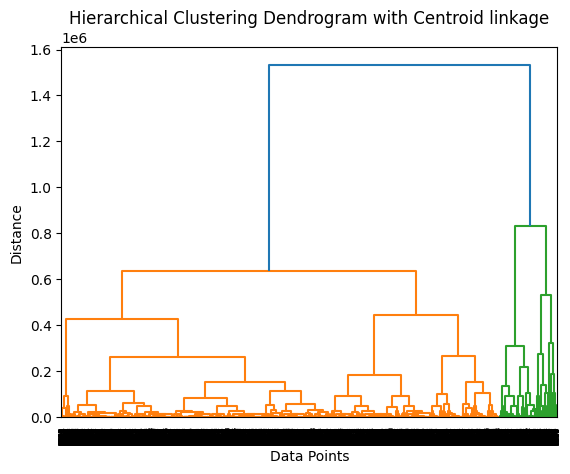

In [68]:
# Perform hierarchical clustering using AgglomerativeClustering with Centroid linkage
# You can adjust the number of clusters and linkage type as needed
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster_labels = clustering.fit_predict(data_scaler_cleaned)

# Print cluster assignments
print("Cluster Labels:", cluster_labels)

# Plot dendrogram for visualization
linkage_matrix = linkage(data_scaler_cleaned, 'centroid')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram with Centroid linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

For centroid Linkage the number of clusters seems to be 2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster Labels: [0 0 1 ... 0 0 0]


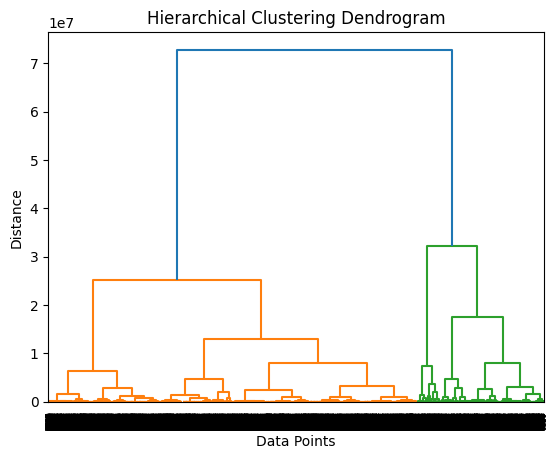

In [61]:
# Perform hierarchical clustering using AgglomerativeClustering with ward linkage
# You can adjust the number of clusters and linkage type as needed
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster_labels = clustering.fit_predict(data_scaler_cleaned)

# Print cluster assignments
print("Cluster Labels:", cluster_labels)

# Plot dendrogram for visualization
linkage_matrix = linkage(data_scaler_cleaned, 'ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram with ward linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

For ward Linkage the number of clusters seems to be 2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster Labels: [0 0 2 ... 0 0 0]


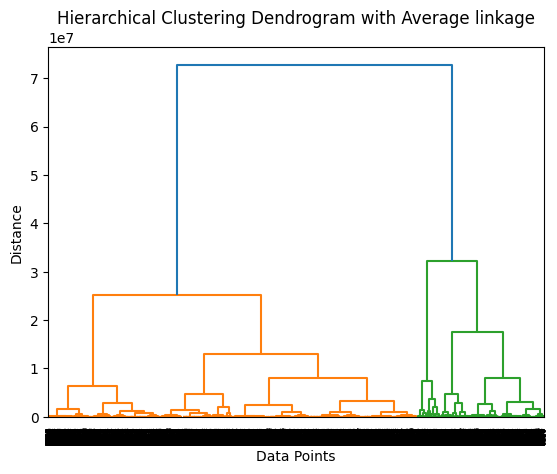

In [62]:
# Perform hierarchical clustering using AgglomerativeClustering with Average linkage
# You can adjust the number of clusters and linkage type as needed
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average')
cluster_labels = clustering.fit_predict(data_scaler_cleaned)

# Print cluster assignments
print("Cluster Labels:", cluster_labels)

# Plot dendrogram for visualization
linkage_matrix = linkage(data_scaler_cleaned, 'average')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram with Average linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

For average Linkage the number of clusters seems to be 2

**Insights**

Number of clusters around 2 seems optimal in most cases, while in last plot(with single linkage) number of clusters around 16 is optimal

# **Insights/ Recommendations**

**Insights**

1.	Top Paying job titles include 'Engineering Leadership', 'Backend Engineer', 'Product Manager', 'Program Manager', 'SDET', 'QA Engineer', 'Data Scientist', 'Android Engineer' and 'FullStack Engineer'.

2.	Avg CTC seems to be decreasing with year.

3.	Top paying companies include ‘Xzabvd’, Sgsg Xzaxv Rru', ' Ihgnxtzn Ntwyzgrgsj Xzw Egqbtqrj Wghugzowgb', Exatrxnj Xzctonbtzno Xzaxv Ucn Rna', ' Hzxctqovr Tmhoxztoo’.

4.	Among top paying companies, salary for these is getting lesser in recent years Hzxctqovr Tmhoxztoo’ , ' Ihgnxtzn Ntwyzgrgsj Xzw Egqbtqrj Wghugzowgb', ‘Xzabvd’, Sgsg Xzaxv Rru', , Exatrxnj Xzctonbtzno Xzaxv Ucn Rna'.

5.	Among Top paying companies mean salary for these company is increasing every year, Vbvkgz, Ovrtoegqwt, Hzxrtctq


**Recommendations**

1. Freshers who want to work on technical side should look for roles related to Backend Engineer, SDET, QA engineer, Dataa Scientist, Android Engineer,Full stack engineer to get good salaries as expirience increases.

2. Freshers who want best CTC should aim for companies like ‘Xzabvd’, Sgsg Xzaxv Rru', ' Ihgnxtzn Ntwyzgrgsj Xzw Egqbtqrj Wghugzowgb', Exatrxnj Xzctonbtzno Xzaxv Ucn Rna', ' Hzxctqovr Tmhoxztoo’.